In [150]:
#!pip install torch

In [151]:
#!pip install torch-geometric
#!pip install -q torch-sparse
#!pip install torch-scatter
#!pip install wandb

In [152]:
#!pip install pytorch-ignite


# Login to Weights and biases

In [153]:
#!wandb login 

# Libraries

In [154]:
from queries import*
from utilities import*
from scipy.spatial import Delaunay
from numpy import linalg
from sklearn import preprocessing
import copy
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, global_max_pool
import torch
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import GATConv

import wandb
#wandb.init(project="GNN-DEEP-MELO")
PLOT_DIRECTORY = './plots/GNN/'

In [155]:
plt.rcParams['font.size'] = '12'

# Function

In [156]:
def labeling(string):
    Patients_CR = ['1C', '1Y', '1N', '1J', '2Y', '1O', '1P','3H','1T','3M','3D','2A','2F','1R'] 
    if str(string)[0:2] in Patients_CR:
        return 1
    else:
        return 0

In [157]:
def edges_to_tensor(edge_df):
    
    patch_number_1 = edge_df.patch_number_1.values
    patch_number_2 = edge_df.patch_number_2.values
    
    edges_index = torch.tensor([patch_number_1,patch_number_2])
    
    return edges_index


In [158]:
def shuffle_and_pick(liste, number):
    
    
    random.shuffle(liste)
    train_indicies = liste[:number]
    test_indicies =liste[number:]
    random.seed()

    
    return train_indicies, test_indicies

In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## Data

# Getting labels 

In [160]:
Directory = os.getcwd()
Directory_path = Directory + '/data/output'
files = os.listdir(Directory_path)

labels = []
patients_name = []
labels_df = pd.DataFrame({},columns =['patient','label'])

for file in files[:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition = ''
        
    
    if condition == 'DEEPMEL':
        
        labels.append(labeling(PATIENT_ID))
        patients_name.append(PATIENT_ID)
        
labels_df['patient'] = patients_name
labels_df['label'] = labels

labels_df = labels_df.drop_duplicates(['patient']).reset_index().drop(['index'],axis=1)

In [161]:
len(labels_df)

63

In [162]:
labels_df.to_csv(Directory_path + '/patients_labels.csv', index= False)

## Defining Graph Dataset

In [163]:
def get_graph_objects(label_csv_file, patch_features_root_dir, transform_edges = edges_to_tensor):
    
    patient_labels_df = pd.read_csv(label_csv_file)
    
    patient_names = patient_labels_df.patient.values
    
    data_list = []
    
    for index,patient_name in enumerate(patient_names):
        
        patient_folder =  patch_features_root_dir + '/DEEPMEL_' + patient_name
        
        patch_features_df = pd.read_csv(patient_folder +'/patch_data_1.csv')
        patch_features_df = patch_features_df.sort_values(['patch_number']).set_index(['patch_number'])
        patch_features_df = patch_features_df.fillna(0)

        patch_edges_df = pd.read_csv(patient_folder +'/patch_edge_data.csv')
        

        x = torch.from_numpy(patch_features_df.drop(['patch', 'cell_x_position', 'cell_y_position'], axis=1).values)
        
        edge_index = transform_edges(patch_edges_df)
        
        y = torch.tensor(patient_labels_df[patient_labels_df.patient == patient_name ].label.values)
        
        data = Data(x = x, edge_index= edge_index, y=y)
        
        data_list.append(data)
   
    return data_list

In [164]:
patients_dataset = get_graph_objects(Directory_path + '/patients_labels.csv',Directory_path )

## Training testing partition

In [165]:
index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

In [166]:
BATCH_SIZE = 12

In [167]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [168]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 12
Batch(batch=[1512], edge_index=[2, 5472], ptr=[13], x=[1512, 64], y=[12])

Step 2:
Number of graphs in the current batch: 12
Batch(batch=[2770], edge_index=[2, 10250], ptr=[13], x=[2770, 64], y=[12])

Step 3:
Number of graphs in the current batch: 12
Batch(batch=[1754], edge_index=[2, 6310], ptr=[13], x=[1754, 64], y=[12])

Step 4:
Number of graphs in the current batch: 8
Batch(batch=[694], edge_index=[2, 2412], ptr=[9], x=[694, 64], y=[8])



In [169]:
for step, data in enumerate(test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 12
Batch(batch=[1812], edge_index=[2, 6612], ptr=[13], x=[1812, 64], y=[12])

Step 2:
Number of graphs in the current batch: 7
Batch(batch=[931], edge_index=[2, 3384], ptr=[8], x=[931, 64], y=[7])



# Models

# GCN Two layers graph convolutional neural networks 

The graph convolutional operator from the "Semi-supervised Classification with Graph Convolutional Networks" paper
$$
\mathbf{X}^{\prime}=\hat{\mathbf{D}}^{-1 / 2} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-1 / 2} \mathbf{X} \boldsymbol{\Theta}
$$
where $\hat{\mathbf{A}}=\mathbf{A}+\mathbf{I}$ denotes the adjacency matrix with inserted self-loops and $\hat{D}_{i i}=\sum_{j=0} \hat{A}_{i j}$ its diagonal degree matrix. The adjacency matrix can include other values than 1 representing
edge weights via the optional edge_weight tensor.
Its node-wise formulation is given by:
$$
\mathbf{x}_{i}^{\prime}=\boldsymbol{\Theta} \sum_{j \in \mathcal{N}(v) \cup\{i\}} \frac{e_{j, i}}{\sqrt{\hat{d}_{j} \hat{d}_{i}}} \mathbf{x}_{j}
$$
with $\hat{d}_{i}=1+\sum_{j \in \mathcal{N}(i)} e_{j, i}$, where $e_{j, i}$ denotes the edge weight from source node $\mathrm{j}$ to target node $i$ (default: $1.0$ )
PARAMETERS:
- in_channels (int) - Size of each input sample.
- out_channels (int) - Size of each output sample.
- improved (bool, optional) - If set to True, the layer computes $\hat{\mathbf{A}}$ as $\mathbf{A}+2 \mathbf{I}$. (default: False)
- cached (bool, optional) - If set to True, the layer will cache the computation of $\hat{\mathbf{D}}^{-1 / 2} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-1 / 2}$ on first execution, and will use the cached version for further executions. This parameter should only be
set to True in transductive learning scenarios. (default: False)
- add_self_loops (bool, optional) - If set to Fatse, will not add self-loops to the input graph. (default: True)

- normalize (bool, optional) – Whether to add self-loops and compute symmetric normalization coefficients on the fly. (default: True)

- bias (bool, optional) – If set to False, the layer will not learn an additive bias. (default: True)

**kwargs (optional) – Additional arguments of torch_geometric.nn.conv.MessagePassing.

In [319]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self,in_channels, hidden_channels, n_classes, P):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels, add_self_loops = True)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops = True)
        self.lin = Linear(hidden_channels, n_classes)

    def forward(self, data, P=0.8):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=P, training=self.training)
        x = self.lin(x)
        
        return x



# Training and evaluation

In [320]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [321]:
def train():
    model.train()
    LOSS = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data)
        #print(data.y)
        #print(out)# Perform a single forward pass.
        loss = criterion(out, data.y)# Compute the loss.
        LOSS.append(np.double(loss.detach().numpy()))
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()
        
    return LOSS


def valid():

    model.eval()
    TEST_LOSS = []
    
    for data in test_loader:  # Iterate in batches over the training dataset.
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y)# Compute the loss.
        TEST_LOSS.append(np.double(loss.detach().numpy()))
       
        
    return TEST_LOSS
    
        
        
        

def test(loader):
    model.eval()
   
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    correct = 0
    
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data)  
        pred = out.argmax(dim=1) # Use the class with highest probability.
        correct += int((pred == data.y).sum())
        #print('pred:',pred)
        #print('true:',data.y)
        #print(confusion_matrix(np.array(data.y),np.array(pred)).ravel())
        tn, fp, fn, tp = confusion_matrix(np.array(data.y),np.array(pred), labels=[0,1]).ravel()
        if len(confusion_matrix(np.array(data.y),np.array(pred), labels=[0,1]).ravel()) >1 :
            TP += tp
            FP += fp
            FN += fn
            TN += tn
        else : 
            if (np.array(data.y)[0]==0):
                TN += len(confusion_matrix(np.array(data.y),np.array(pred), labels=[0,1]).ravel()) 
                
            else :
                TP += len(confusion_matrix(np.array(data.y),np.array(pred), labels=[0,1]).ravel())
            
       
        
    #print(TP, FP, FN)
    precision_1 = TP /(TP+FP)
    recall_1 = TP / (TP+FN)
    precision_0 = TN /(TN+FN)
    recall_0 = TN / (TN+FP)
    return correct / len(loader.dataset), precision_1, recall_1,precision_0, recall_0# Derive ratio of correct predictions.

###  GCN : Fixing Model HyperParameters

In [324]:
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#wandb.init(project='oncology-project')

Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3
ALPHA = 5
GAMMA = 5 



model = GCN(IN_CHANNELS,HIDDEN_CHANNELS,N_CLASSES, DROPOUT).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1


WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
#criterion = FocalLoss(GAMMA,ALPHA)





LOSS_epoch_GCN = []
TOTAL_LOSS = []
TEST_epoch = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy = []
Test_accuracy = []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch_GCN.append(np.mean(loss))
    TEST_epoch.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy.append(train_acc)
    Test_accuracy.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    
    

[197.5274526558746, 805.5939232564557, 501.15504051975677, 866.3784759881639, 476.612798908319]
test
Epoch: 001, Train Acc: 0.6364, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[12.103674408358522, 0.49482407776855913, 276.2337556185797, 18.99405957484918, 0.7704562956828834]
test
Epoch: 002, Train Acc: 0.7045, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[47.08479023571375, 21.348975324326425, 3.7223266518795897, 86.41992451896974, 0.3953299148000246]
test
Epoch: 003, Train Acc: 0.7500, Test Acc: 0.5789, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7333,recall_0: 0.7333
[23.100862070616472, 7.729440164767834, 230.42119954086496, 34.343259964963124, 79.47587781989075]
test
Epoch: 004, Train Acc: 0.7045, Test Acc: 0.6842, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7647,recall_0: 0.8667
[8.415938273029221, 1.103225089619886, 1.230568640421233, 0.8376177515709738, 1.6342237778

test
Epoch: 038, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.2500, recall_1: 0.2500,precision_0: 0.8000,recall_0: 0.8000
[0.5629787964959839, 0.7170344433167393, 0.6607093646431462, 0.5109302331917355, 0.5921411668195812]
test
Epoch: 039, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.2500, recall_1: 0.2500,precision_0: 0.8000,recall_0: 0.8000
[0.5496136067469364, 0.6703642583309632, 0.6775236454791148, 0.7190168787587214, 0.7591198402148358]
test
Epoch: 040, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.2500, recall_1: 0.2500,precision_0: 0.8000,recall_0: 0.8000
[0.6000606384803573, 0.6430871499472169, 0.7554294816771324, 0.7147565866009029, 0.7085749974246863]
test
Epoch: 041, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.2500, recall_1: 0.2500,precision_0: 0.8000,recall_0: 0.8000
[0.6852380450895803, 0.6414585965961533, 0.6423983354803344, 0.7140733795200158, 0.7622085619462656]
test
Epoch: 042, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.2500, recal

Epoch: 074, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.2500, recall_1: 0.2500,precision_0: 0.8000,recall_0: 0.8000
[0.6781501805898935, 0.7201632916039579, 0.5925319454556551, 0.683209464330069, 0.7003507389057982]
test
Epoch: 075, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.2500, recall_1: 0.2500,precision_0: 0.8000,recall_0: 0.8000
[0.6764545415067686, 0.6599926726497445, 0.7245275643543468, 0.5916534271459454, 0.7005050083444951]
test
Epoch: 076, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[0.6831516963831861, 0.7411051723890332, 0.641766355795081, 0.5301994188602551, 0.7003537976476958]
test
Epoch: 077, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[0.6467704804580442, 0.6831782741560015, 0.6474374704136422, 0.5028450411931227, 0.7003033862751874]
test
Epoch: 078, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.

test
Epoch: 110, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[0.7405638277694901, 0.36238272562296736, 0.6153494739262073, 0.8090233252481529, 0.6256451479270426]
test
Epoch: 111, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[0.534255901565178, 0.8084565742393784, 0.4908237489782333, 0.5460360931314043, 0.4171334085280962]
test
Epoch: 112, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[0.8052872380960567, 0.5715800012976454, 0.7190058625214595, 0.43111450367719895, 0.805750298213228]
test
Epoch: 113, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[0.5293815035254048, 0.4571342327676241, 0.7458396553924002, 0.588349727862029, 0.682068172184278]
test
Epoch: 114, Train Acc: 0.8409, Test Acc: 0.5789, precision_1: 0.0000, recall_

test
Epoch: 148, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.6829181987308851, 0.7206032444219083, 0.6335463076824123, 0.6141785266234896, 0.6083846424511279]
test
Epoch: 149, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.5074860886598682, 0.6346410977520297, 0.566853703982617, 0.7714147105463167, 0.5916807105735462]
test
Epoch: 150, Train Acc: 0.8409, Test Acc: 0.6842, precision_1: 0.2500, recall_1: 0.2500,precision_0: 0.8000,recall_0: 0.8000
[0.633805977227963, 0.7579369910939743, 0.6829305988399673, 0.6267224419135672, 0.3651288206913865]
test
Epoch: 151, Train Acc: 0.8636, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[0.7189402173383238, 0.7190980355779597, 0.5615881599394411, 0.4814265708519356, 0.5686231046137129]
test
Epoch: 152, Train Acc: 0.8636, Test Acc: 0.6316, precision_1: 0.2000, recall_

[0.4998815799369275, 0.6888772397446017, 0.643000745086923, 0.5839271914851264, 0.6470728820150592]
test
Epoch: 186, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.5359646608645823, 0.6829109263950308, 0.7178842131530038, 0.5399938455163514, 0.2851029533534368]
test
Epoch: 187, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.5882469701948979, 0.5885183709513456, 0.7168782721729385, 44.182469311249854, 0.6240733577906435]
test
Epoch: 188, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.459063857786347, 0.7169020496243551, 0.6444967610720981, 0.7202707050625511, 0.58098260338471]
test
Epoch: 189, Train Acc: 0.8636, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.6218859493262617, 0.6191906719662827, 0.8357472038802021, 0.7067151040119887, 0.6

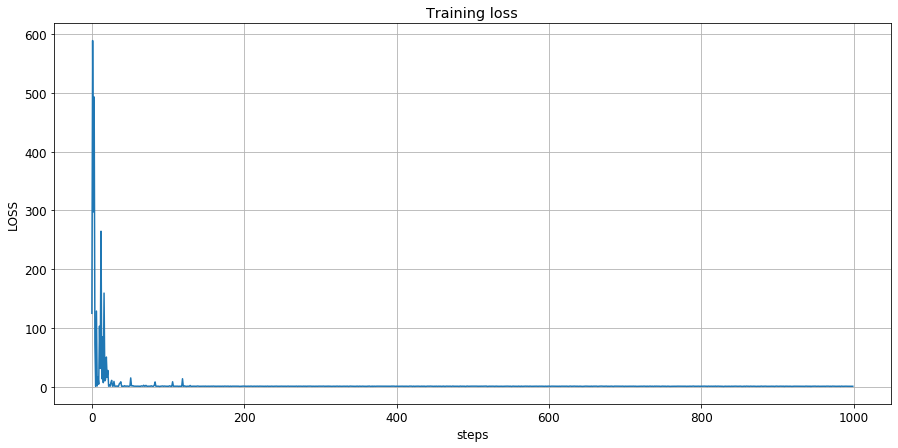

In [314]:
plt.figure(figsize=(15,7))
n = len(TOTAL_LOSS)
plt.plot(range(n),TOTAL_LOSS[:]   )


plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.title( 'Training loss' )
plt.savefig(PLOT_DIRECTORY + 'Training_loss: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')  

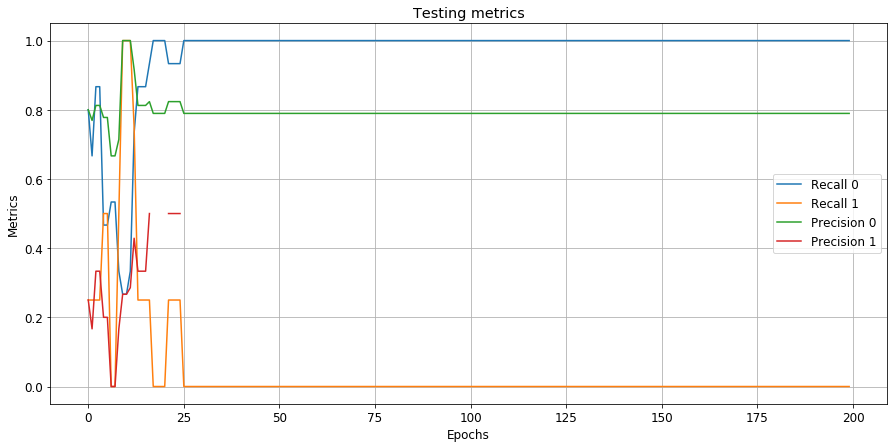

In [315]:
plt.figure(figsize=(15,7))
n = len(recall_class_0)
x_axis = range(n)
plt.plot(x_axis,recall_class_0, label = 'Recall 0'  )
plt.plot(x_axis,recall_class_1, label = 'Recall 1'  )
plt.plot(x_axis,precision_class_0, label = 'Precision 0'  )
plt.plot(x_axis,precision_class_1, label = 'Precision 1'  )
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Testing metrics')
plt.legend()
plt.grid()
plt.savefig(PLOT_DIRECTORY + 'Test_recall_precision: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

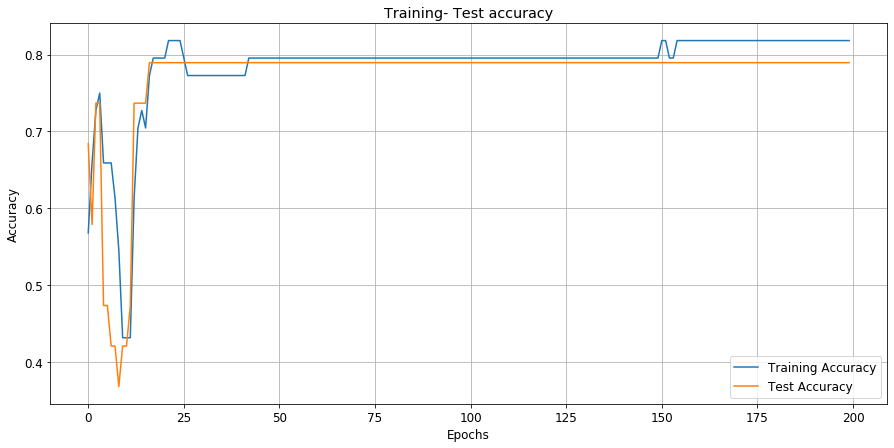

In [316]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),Train_accuracy[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy[:], label= 'Test Accuracy' )



plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')


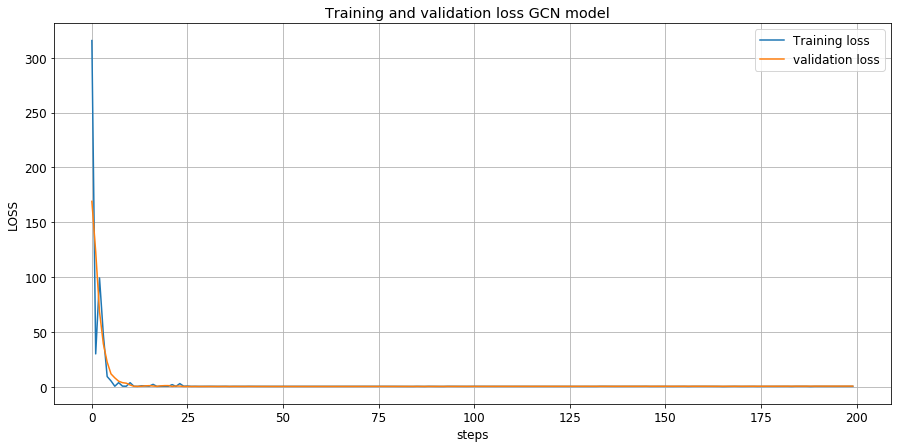

In [318]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),LOSS_epoch_GCN[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch[:], label= 'validation loss' )



plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training and validation loss GCN model  ' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

## Weights and Biases : Sweeps

In [186]:

sweep_config = {
  "name" : "GCN_sweep",
  "method" : "grid",
   "metric":{
  "name" : "loss"},
  
  "parameters" : {
    "epochs" : {
      "values" : [200]
    },
    "learning_rate" :{
      "min": 0.0001,
      "max": 0.1
    },
      "batch_size" : {
          "distribution" :'int_uniform',
          "min":1,
          "max":40
      },
      
      "class_1_weight": {
          
          "min":1,
          "max":20
      }
      
      
  }
}

#sweep_id = wandb.sweep(sweep_config,project='oncology-project')

In [187]:
#def train_1():
#    with wandb.init() as run:
#        config = wandb.config
#        BATCH_SIZE = config["batch_size"]
#        LR = config["learning_rate"]
#        DROPOUT = 0
#        CLASS_1_WEIGHT = config["class_1_weight"]
#        WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
        
#        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)    
        
        
#        model = GCN(IN_CHANNELS,HIDDEN_CHANNELS,N_CLASSES, DROPOUT).double()
        
#        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#        criterion = torch.nn.CrossEntropyLoss(WEIGHTS).double()
    
#        for epoch in range(1, 201):
#            loss = train()
#            avg_loss = np.mean(loss)
#            wandb.log({"loss": np.mean(loss)})
        

#count = 10 # number of runs to execute
#wandb.agent(sweep_id = 'x8o354ox', function=train_1,count=count)

## 10-fold Cross validation  

In [388]:
N_FOLDS = 10
Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3
ALPHA = 5
GAMMA = 5
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)





WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)


TRAIN_ACC_BOXPLOT = []
TEST_ACC_BOXPLOT = []
RECALL_1_BOXPLOT = []
RECALL_0_BOXPLOT = []
PRECISION_1_BOXPLOT = []
PRECISION_0_BOXPLOT = []
CONVERGED_TRAINING_LOSS = []
CONVERGED_VALID_LOSS = []


for step in range(N_FOLDS):
    
    print('Fold : ',step)
 
    model = GCN(IN_CHANNELS,HIDDEN_CHANNELS,N_CLASSES, DROPOUT).double()
    criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
    opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)
    opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)
    optimizer = opt_1
    
    train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
    train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)
    

    train_indicies = train_indicies_class_1 + train_indicies_class_0
    test_indicies = test_indicies_class_1 + test_indicies_class_0 

    train_dataset = [patients_dataset[i] for i in train_indicies] 
    test_dataset = [patients_dataset[i] for i in test_indicies]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
    
  
    
    LOSS_epoch = []
    TOTAL_LOSS = []
    TEST_epoch = []
    recall_class_0 =[]
    precision_class_0 =[]
    recall_class_1 =[]
    precision_class_1 =[]

    Train_accuracy = []
    Test_accuracy = []


    for epoch in range(1, 201):
        loss = train()
        test_loss = valid()
        #print(loss)
        TOTAL_LOSS = TOTAL_LOSS + loss
        LOSS_epoch.append(np.mean(loss))
        TEST_epoch.append(np.mean(test_loss))
        train_acc = test(train_loader)[0]
        #print('test')
        test_acc = test(test_loader)[0]
        recall_1 = test(test_loader)[2]
        precision_1 = test(test_loader)[1]
        precision_0 = test(test_loader)[3]
        recall_0 = test(test_loader)[4]
    
        recall_class_0.append(recall_0)
        recall_class_1.append(recall_1)
    
        precision_class_0.append(precision_0)
        precision_class_1.append(precision_1)
   
        Train_accuracy.append(train_acc)
        Test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
        
    TRAIN_ACC_BOXPLOT.append(train_acc)
    TEST_ACC_BOXPLOT.append(test_acc)
    RECALL_1_BOXPLOT.append(recall_1)
    RECALL_0_BOXPLOT.append(recall_0)
    PRECISION_1_BOXPLOT.append(precision_1)
    PRECISION_0_BOXPLOT.append(precision_0)
    CONVERGED_TRAINING_LOSS.append(np.mean(loss))
    CONVERGED_VALID_LOSS.append(np.mean(test_loss))  



Fold :  0


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 0.7955, Test Acc: 0.6842, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7647,recall_0: 0.8667
Fold :  1
Epoch: 200, Train Acc: 0.8864, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
Fold :  2
Epoch: 200, Train Acc: 0.7955, Test Acc: 0.7368, precision_1: 0.3333, recall_1: 0.2500,precision_0: 0.8125,recall_0: 0.8667
Fold :  3
Epoch: 200, Train Acc: 0.8182, Test Acc: 0.8421, precision_1: 0.6667, recall_1: 0.5000,precision_0: 0.8750,recall_0: 0.9333
Fold :  4
Epoch: 200, Train Acc: 0.7273, Test Acc: 0.4211, precision_1: 0.1111, recall_1: 0.2500,precision_0: 0.7000,recall_0: 0.4667
Fold :  5
Epoch: 200, Train Acc: 0.8409, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
Fold :  6
Epoch: 200, Train Acc: 0.8636, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
Fold :  7
Epoch: 200, Train Acc: 0.8409, Test Acc: 0.7895, precision_1: 

In [392]:
losses = pd.DataFrame({},columns =['training_loss', 'validation_loss'])
losses['training_loss'] = CONVERGED_TRAINING_LOSS
losses['validation_loss'] = CONVERGED_VALID_LOSS

In [393]:
metrics = pd.DataFrame({},columns =['train accuracy', 'test accuracy', 'recall_1', 'precision_1', 'recall_0','precision_0'])
metrics['train accuracy'] = TRAIN_ACC_BOXPLOT
metrics['test accuracy'] = TEST_ACC_BOXPLOT
metrics['recall_1'] = RECALL_1_BOXPLOT
metrics['recall_0'] = RECALL_0_BOXPLOT
metrics['precision_1'] = PRECISION_1_BOXPLOT
metrics['precision_0'] = PRECISION_0_BOXPLOT

metrics.to_csv('./data/output/metrics/GCN.csv', index=False)

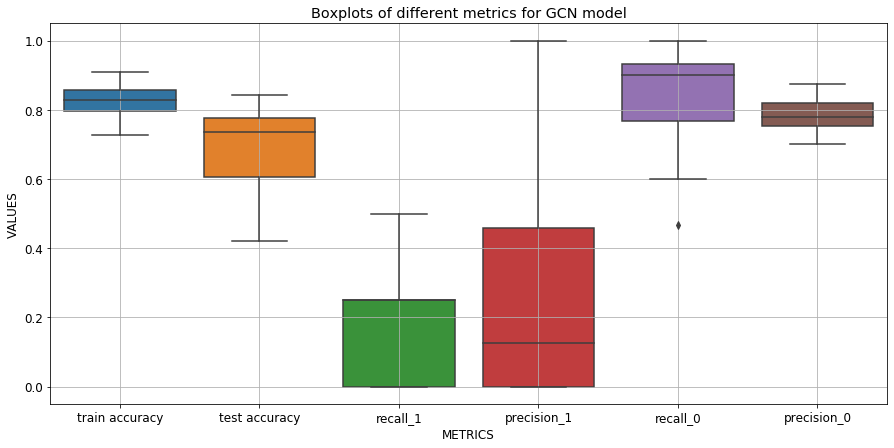

In [391]:
plt.figure(figsize=(15,7))
sns.boxplot(data=metrics)
plt.xlabel('METRICS')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for GCN model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

# GAT 

The graph attentional operator from the "Graph Attention Networks" paper
$$
\mathbf{x}_{i}^{\prime}=\alpha_{i, i} \boldsymbol{\Theta} \mathbf{x}_{i}+\sum_{j \in \mathcal{N}(i)} \alpha_{i, j} \boldsymbol{\Theta} \mathbf{x}_{j}
$$
where the attention coefficients $\alpha_{i, j}$ are computed as
$$
\alpha_{i, j}=\frac{\exp \left(\operatorname{LeakyReLU}\left(\mathbf{a}^{\top}\left[\boldsymbol{\Theta} \mathbf{x}_{i} \| \boldsymbol{\Theta} \mathbf{x}_{j}\right]\right)\right)}{\sum_{k \in \mathcal{N}(i) \cup\{i\}} \exp \left(\operatorname{LeakyReLU}\left(\mathbf{a}^{\top}\left[\boldsymbol{\Theta} \mathbf{x}_{i} \| \boldsymbol{\Theta} \mathbf{x}_{k}\right]\right)\right)}
$$
PARAMETERS:\
$\quad$ - in_channels (int or tuple) - Size of each input sample. A tuple corresponds to the sizes of source and target dimensionalities.
- out_channels (int) - Size of each output sample.
- heads (int, optional) - Number of multi-head-attentions. (default: 1 )
- concat (bool, optional) - If set to Fatse, the multi-head attentions are
averaged instead of concatenated. (default: True )
- negative_slope (float, optional) - LeakyReLU angle of the negative slope. (default: $0.2$ )
- dropout (float, optional) - Dropout probability of the normalized attention coefficients which exposes each node to a stochastically sampled neighborhood during training. (default: 0 )
- add_self_loops (bool, optional) - If set to False, will not add self-loops
to the input graph. (default: True )
- bias (bool, optional) - If set to False, the layer will not learn an additive
bias. (default: True)
- $^{* *}$ kwargs (optional) - Additional arguments of
torch_geometric.nn. conv.MessagePassing.

In [291]:
class GAT(nn.Module):
    def __init__(self, hidden_channels, out_channels, first_heads, output_heads, dropout):
        super(GAT, self).__init__()
        self.gc1 = GATConv(64, hidden_channels,
                           heads=first_heads, dropout=dropout)
        
        self.gc2 = GATConv(hidden_channels*first_heads, hidden_channels,
                           heads=output_heads, dropout=dropout)
        
        self.dropout = dropout
        self.lin = Linear(hidden_channels, 2)


    def reset_parameters(self):
        self.gc1.reset_parameters()
        self.gc2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch= data.x, data.edge_index, data.batch
        #x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gc1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gc2(x, edge_index)
        x = F.relu(x)
        
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1)

In [325]:
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#wandb.init(project='oncology-project')

Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3




model = GAT( hidden_channels =BATCH_SIZE, out_channels =2,first_heads=8, output_heads=1, dropout=DROPOUT).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1


WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
#criterion = FocalLoss(GAMMA,ALPHA)

LOSS_epoch_GAT = []
TOTAL_LOSS = []
TEST_epoch = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy = []
Test_accuracy = []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch_GAT.append(np.mean(loss))
    TEST_epoch.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy.append(train_acc)
    Test_accuracy.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    
    

[101.54249455970272, 408.43501626136856, 383.9645513482575, 24.921705641056764, 20.501952179526906]
test
Epoch: 001, Train Acc: 0.6591, Test Acc: 0.5263, precision_1: 0.2727, recall_1: 0.7500,precision_0: 0.8750,recall_0: 0.4667
[36.276111550036646, 135.77978783860988, 26.993849630615653, 56.35374138304249, 30.520325062681422]
test
Epoch: 002, Train Acc: 0.7045, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[30.429445083431222, 48.29128082454422, 45.96260294196962, 51.97787148657121, 26.030021297026522]
test
Epoch: 003, Train Acc: 0.7955, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[35.50107935664695, 0.6762262510291224, 2.36737566327768, 44.57219581957642, 0.04095509665813538]
test
Epoch: 004, Train Acc: 0.7955, Test Acc: 0.5789, precision_1: 0.3000, recall_1: 0.7500,precision_0: 0.8889,recall_0: 0.5333
[26.485615848873394, 2.773169522780388e-09, 36.857909009937195, 21.285869341423798, 1.50

Epoch: 036, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.7500,precision_0: 0.9091,recall_0: 0.6667
[0.0038324423680136735, 0.03332692024750432, 0.07527938005548128, 0.03380891173067705, 0.0819047695167326]
test
Epoch: 037, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.7500,precision_0: 0.9091,recall_0: 0.6667
[0.012006334190533033, 0.03927455564329833, 0.026620131487298162, 0.08882145854698367, 0.0]
test
Epoch: 038, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.7500,precision_0: 0.9091,recall_0: 0.6667
[0.04341406406850862, 0.06327214233701726, 0.0054976387669977205, 0.05623228816714914, 0.0]
test
Epoch: 039, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.7500,precision_0: 0.9091,recall_0: 0.6667
[0.035785687561089664, 0.06611672342889514, 0.058931784788551926, 0.01375258515019939, 0.00037437713044609496]
test
Epoch: 040, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.

[0.024679502965885454, 0.019534002930821494, 0.0026980868074694673, 0.010783251691714991, 0.001484209355654309]
test
Epoch: 072, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.7500,precision_0: 0.9091,recall_0: 0.6667
[0.006917985549625533, 0.03908214920511895, 5.439143892789017e-06, 0.006296594908152165, 0.0]
test
Epoch: 073, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.7500,precision_0: 0.9091,recall_0: 0.6667
[0.0007254783584210318, 0.019749106215145498, 0.012940344488256183, 0.015679491488572866, 0.006718911112943423]
test
Epoch: 074, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.7500,precision_0: 0.9091,recall_0: 0.6667
[0.014320733441572015, 0.02503599311914545, 0.00877685130787018, 0.004861063324002504, 0.002153675695061828]
test
Epoch: 075, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.7500,precision_0: 0.9091,recall_0: 0.6667
[0.0419017674039377, 0.0012651935845819679, 0.00801851600

test
Epoch: 106, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.00010811966899421563, 0.0006353545509545923, 0.010556553079346212, 0.021030488842749117, 0.0027063637443040327]
test
Epoch: 107, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.0008682939673308877, 0.02447449403356195, 0.000624245238420242, 0.0008438794840615165, 0.017815554566413396]
test
Epoch: 108, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.014022447981126372, 9.933290408815135e-05, 0.0007367053591239085, 0.0007414879724138326, 0.02937910296158706]
test
Epoch: 109, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.014148217115312901, 0.011211588479198786, 6.209218389360888e-05, 0.0014200374259704014, 0.0005900525475921074]
test
Epoch: 110, Train Acc: 1.

[0.014425926195226788, 4.3899900824938265e-05, 0.005004991612891326, 0.000703015558712644, 0.00016718712568013656]
test
Epoch: 141, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.0014201563326849266, 0.015473605599850443, 9.597009850910855e-05, 6.109966612443192e-05, 0.017333454536743884]
test
Epoch: 142, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.005630648198743692, 2.187690420004624e-05, 0.0008410779505500227, 0.015103402017336674, 0.0006759422692538212]
test
Epoch: 143, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.00032848910436615705, 0.0001582028457573018, 0.006663175488000901, 0.013231243797176261, 0.0016964184332136454]
test
Epoch: 144, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.004705908220515616, 0.0

[0.010856090728741457, 4.8818101161078855e-05, 0.002915208539237045, 7.255060491487125e-05, 0.0016959966218890261]
test
Epoch: 175, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.012054485993161654, 0.00011333083319949532, 0.0005501888163333611, 0.0031664351195206898, 0.0015732205325222487]
test
Epoch: 176, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[5.7291263855184835e-06, 6.806966870057778e-05, 0.01628205376723977, 0.0004876381767103828, 0.0003125988392754337]
test
Epoch: 177, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[0.000192368534469923, 0.00238989650968058, 0.00013840850006575656, 0.012573148238359788, 0.0009403004483342247]
test
Epoch: 178, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4286, recall_1: 0.7500,precision_0: 0.9167,recall_0: 0.7333
[4.5103100946782615e-05, 

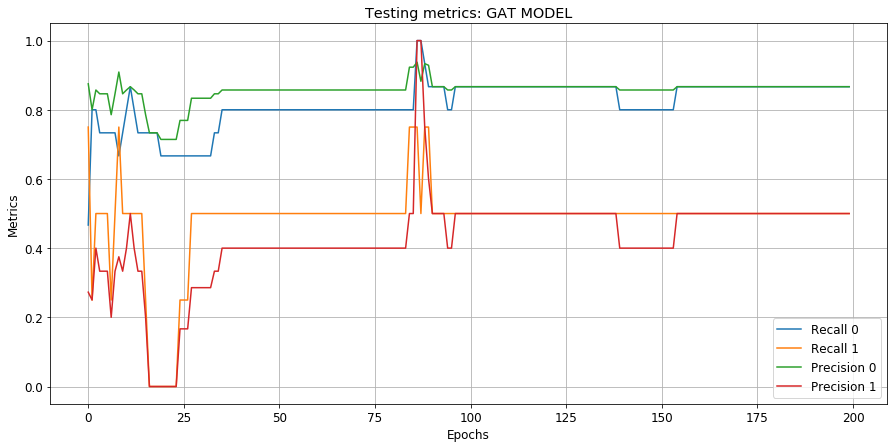

In [293]:
plt.figure(figsize=(15,7))
n = len(recall_class_0)
x_axis = range(n)
plt.plot(x_axis,recall_class_0, label = 'Recall 0'  )
plt.plot(x_axis,recall_class_1, label = 'Recall 1'  )
plt.plot(x_axis,precision_class_0, label = 'Precision 0'  )
plt.plot(x_axis,precision_class_1, label = 'Precision 1'  )
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Testing metrics: GAT MODEL')
plt.legend()
plt.grid()
plt.savefig(PLOT_DIRECTORY + 'Test_recall_precision: model GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

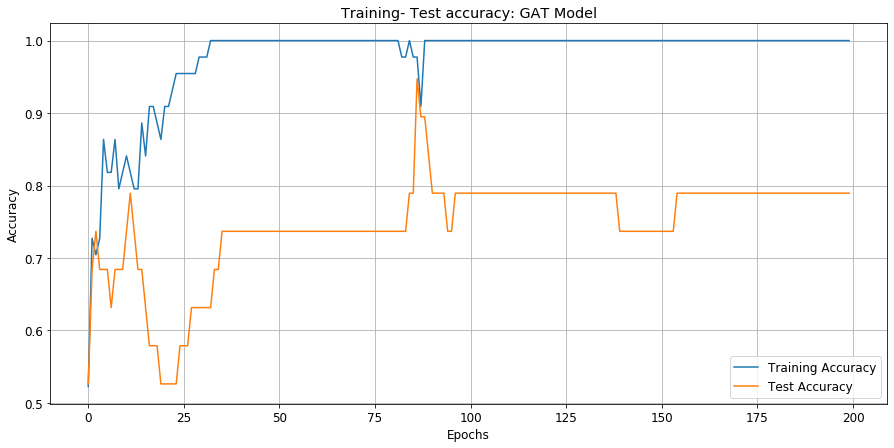

In [294]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_GAT)
plt.plot(range(n),Train_accuracy[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: GAT Model' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')

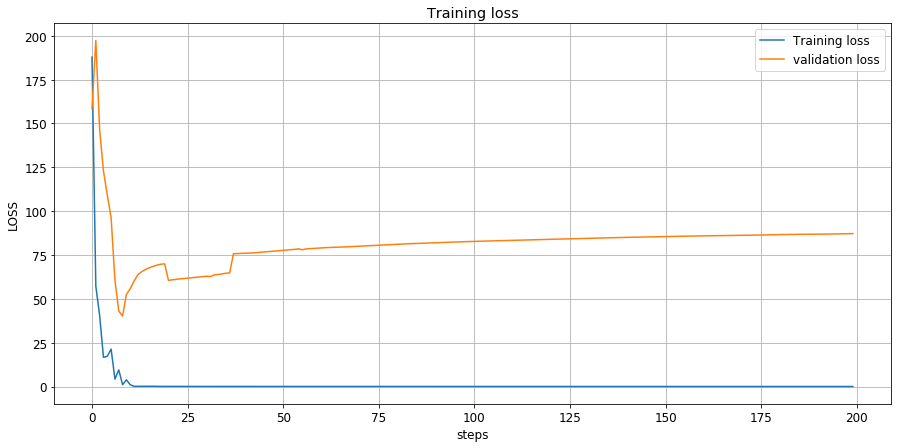

In [326]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_GAT)
plt.plot(range(n),LOSS_epoch_GAT[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch[:], label= 'validation loss' )



plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training loss' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

## GAT CROSS VALIDATION

In [396]:
N_FOLDS = 10
Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)




WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)


TRAIN_ACC_BOXPLOT = []
TEST_ACC_BOXPLOT = []
RECALL_1_BOXPLOT = []
RECALL_0_BOXPLOT = []
PRECISION_1_BOXPLOT = []
PRECISION_0_BOXPLOT = []
CONVERGED_TRAINING_LOSS = []
CONVERGED_VALID_LOSS = []


for step in range(N_FOLDS):
    
    print('Fold : ',step)
 
    model = GAT( hidden_channels =BATCH_SIZE, out_channels =2,first_heads=8, output_heads=1, dropout=DROPOUT).double()
    criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
    opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)
    opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)
    optimizer = opt_1
    
    train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
    train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

    train_indicies = train_indicies_class_1 + train_indicies_class_0
    test_indicies = test_indicies_class_1 + test_indicies_class_0 

    train_dataset = [patients_dataset[i] for i in train_indicies] 
    test_dataset = [patients_dataset[i] for i in test_indicies]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
    
  
    
    LOSS_epoch = []
    TOTAL_LOSS = []
    TEST_epoch = []
    recall_class_0 =[]
    precision_class_0 =[]
    recall_class_1 =[]
    precision_class_1 =[]

    Train_accuracy = []
    Test_accuracy = []


    for epoch in range(1, 201):
        loss = train()
        test_loss = valid()
        #print(loss)
        TOTAL_LOSS = TOTAL_LOSS + loss
        LOSS_epoch.append(np.mean(loss))
        TEST_epoch.append(np.mean(test_loss))
        train_acc = test(train_loader)[0]
        #print('test')
        test_acc = test(test_loader)[0]
        recall_1 = test(test_loader)[2]
        precision_1 = test(test_loader)[1]
        precision_0 = test(test_loader)[3]
        recall_0 = test(test_loader)[4]
    
        recall_class_0.append(recall_0)
        recall_class_1.append(recall_1)
    
        precision_class_0.append(precision_0)
        precision_class_1.append(precision_1)
   
        Train_accuracy.append(train_acc)
        Test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
        
    TRAIN_ACC_BOXPLOT.append(train_acc)
    TEST_ACC_BOXPLOT.append(test_acc)
    RECALL_1_BOXPLOT.append(recall_1)
    RECALL_0_BOXPLOT.append(recall_0)
    PRECISION_1_BOXPLOT.append(precision_1)
    PRECISION_0_BOXPLOT.append(precision_0)
    CONVERGED_TRAINING_LOSS.append(np.mean(loss))
    CONVERGED_VALID_LOSS.append(np.mean(test_loss))  


Fold :  0
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4000, recall_1: 0.5000,precision_0: 0.8571,recall_0: 0.8000
Fold :  1
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
Fold :  2


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.3333, recall_1: 0.2500,precision_0: 0.8125,recall_0: 0.8667
Fold :  3
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
Fold :  4
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
Fold :  5
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
Fold :  6
Epoch: 200, Train Acc: 0.9773, Test Acc: 0.7368, precision_1: 0.4000, recall_1: 0.5000,precision_0: 0.8571,recall_0: 0.8000
Fold :  7
Epoch: 200, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
Fold :  8
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
Fold :  9
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 

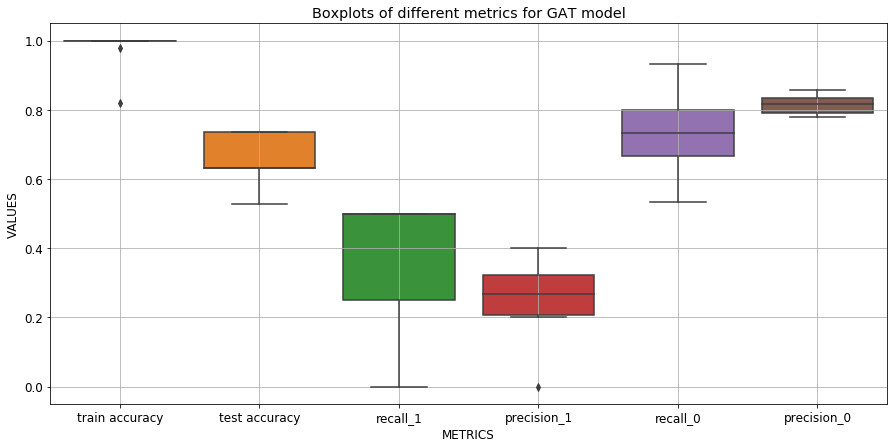

In [397]:
losses_GAT = pd.DataFrame({},columns =['training_loss', 'validation_loss'])
losses_GAT['training_loss'] = CONVERGED_TRAINING_LOSS
losses_GAT['validation_loss'] = CONVERGED_VALID_LOSS


metrics_GAT = pd.DataFrame({},columns =['train accuracy', 'test accuracy', 'recall_1', 'precision_1', 'recall_0','precision_0'])
metrics_GAT['train accuracy'] = TRAIN_ACC_BOXPLOT
metrics_GAT['test accuracy'] = TEST_ACC_BOXPLOT
metrics_GAT['recall_1'] = RECALL_1_BOXPLOT
metrics_GAT['recall_0'] = RECALL_0_BOXPLOT
metrics_GAT['precision_1'] = PRECISION_1_BOXPLOT
metrics_GAT['precision_0'] = PRECISION_0_BOXPLOT

metrics_GAT.to_csv('./data/output/metrics/GAT.csv', index=False)

plt.figure(figsize=(15,7))
sns.boxplot(data=metrics_GAT)
plt.xlabel('METRICS')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for GAT model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS METRICS GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

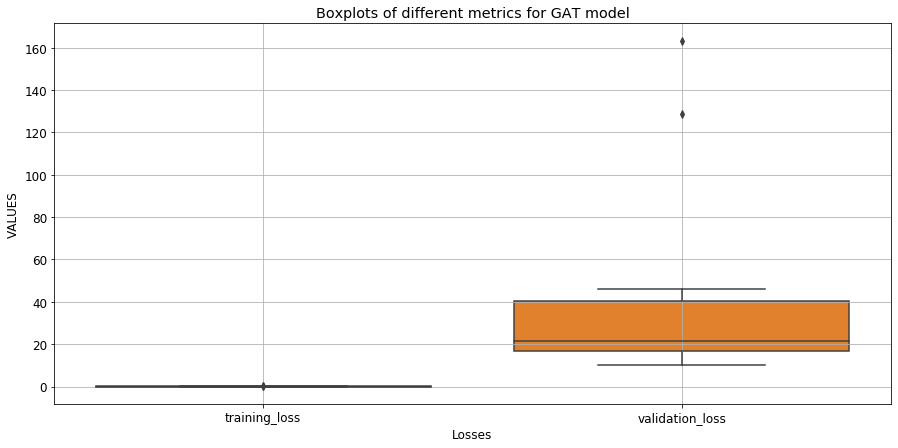

In [247]:
plt.figure(figsize=(15,7))
sns.boxplot(data=losses_GAT)
plt.xlabel('Losses')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for GAT model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS LOSSES GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

# SGC : Simple graph convolution

The simple graph convolutional operator from the "Simplifying Graph Convolutional Networks"
paper
$$
\mathbf{X}^{\prime}=\left(\hat{\mathbf{D}}^{-1 / 2} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-1 / 2}\right)^{K} \mathbf{X} \boldsymbol{\Theta}
$$
where $\hat{\mathbf{A}}=\mathbf{A}+\mathbf{I}$ denotes the adjacency matrix with inserted self-loops and $\hat{D}_{i i}=\sum_{j=0} \hat{A}_{i j}$ its diagonal degree matrix. The adjacency matrix can include other values than 1 representing edge weights via the optional edge_weight tensor.
PARAMETERS:
- in_channels (int) - Size of each input sample.
- out_channels (int) - Size of each output sample.
- $\mathrm{K}$ (int, optional) - Number of hops $K$. (default: 1 )
- cached (bool, optional) - If set to True, the layer will cache the computation of $\left(\hat{\mathbf{D}}^{-1 / 2} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-1 / 2}\right)^{K} \mathbf{X}$ on first execution, and will use the cached version for further executions. This parameter should only be set to True in transductive learning scenarios. (default: False)
- add_self_loops (bool, optional) - If set to Fatse, will not add self-loops to the input graph. (default: True )
- bias (bool, optional) - If set to False, the layer will not learn an additive bias. (default: True)
- $^{* *}$ kwargs (optional) - Additional arguments of torch_geometric.nn. conv.MessagePassing.

In [201]:
from torch_geometric.nn import SGConv


class SGC(nn.Module):
    def __init__(self,hidden_channels, K):
        super(SGC, self).__init__()
        self.gc1 = SGConv(64, hidden_channels, K=K,add_self_loops=True)
        self.gc2 = SGConv(hidden_channels, hidden_channels, K=K,add_self_loops=True)

        self.lin = Linear(hidden_channels, 2)

    def reset_parameters(self):
        self.gc1.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gc1(x, edge_index)
        x= F.relu(x)
        x = self.gc2(x, edge_index)
        x= F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)
    
    

In [202]:
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#wandb.init(project='oncology-project')

Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3
K = 2




model = SGC(hidden_channels=BATCH_SIZE,K=K).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1


WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
#criterion = FocalLoss(GAMMA,ALPHA)

LOSS_epoch = []
TOTAL_LOSS = []
TEST_epoch = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy = []
Test_accuracy = []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch.append(np.mean(loss))
    TEST_epoch.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy.append(train_acc)
    Test_accuracy.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    

[73.03512071141769, 66.34625608232211, 64.23578794647017, 29.886792757182928, 0.9635675486969507]
test
Epoch: 001, Train Acc: 0.6591, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[99.24587767093438, 8.36757348606705, 73.05725657879988, 27.140444077339396, 13.888474792521407]
test
Epoch: 002, Train Acc: 0.5455, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
[12.84630020633331, 16.323156703600798, 41.33288582642255, 38.86415919458677, 69.25129685659532]
test
Epoch: 003, Train Acc: 0.6136, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[21.71604458473019, 24.642821381475585, 3.651834278173456, 1.6915730594899523e-05, 25.0209867412315]
test
Epoch: 004, Train Acc: 0.8409, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000


invalid value encountered in long_scalars


[3.890805561211309, 18.985949077318914, 20.880466403620964, 9.595973200093992, 12.869161307918601]
test
Epoch: 005, Train Acc: 0.8636, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[5.405399676197893, 0.4931996206482465, 1.2319314865756206, 3.887791303351887, 0.0672245110499204]
test
Epoch: 006, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[2.7365904727484125, 7.746679972912507, 4.271283290146991, 4.098815191309512, 0.6202213590008102]
test
Epoch: 007, Train Acc: 0.7727, Test Acc: 0.4211, precision_1: 0.1111, recall_1: 0.2500,precision_0: 0.7000,recall_0: 0.4667
[10.593073107605155, 2.799018974131147, 0.15985804277535823, 6.826323475741336, 8.99160161223995e-06]
test
Epoch: 008, Train Acc: 0.7727, Test Acc: 0.4737, precision_1: 0.1250, recall_1: 0.2500,precision_0: 0.7273,recall_0: 0.5333
[0.20391839372527518, 0.22389485875860685, 8.443105521910725, 0.9749127666558327, 6.56089

[0.19117241204874885, 0.07408710601135782, 0.014931640698782712, 0.0032482275198089192, 0.16793387517466815]
test
Epoch: 040, Train Acc: 0.9545, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[0.08803756750321534, 0.07554450111121169, 0.006022409301165311, 0.15283003590290586, 0.11362448691438844]
test
Epoch: 041, Train Acc: 0.9545, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[0.17390511416311324, 0.0004272347400009676, 0.0719156137306066, 0.036227385141885594, 0.15770964481582417]
test
Epoch: 042, Train Acc: 0.9545, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[0.12403699142403932, 0.15031751351359451, 0.03934129186960708, 0.0015939129030064839, 0.015086129825975248]
test
Epoch: 043, Train Acc: 0.9545, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[0.09707949911780242, 0.10775182362102591, 0.034497

[0.0809558772676249, 0.007973757024145912, 1.1524539858594949e-07, 0.1821880061032912, 0.012059706074034358]
test
Epoch: 075, Train Acc: 0.9545, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[0.002681958030375374, 0.005568287916826692, 0.0974156832709589, 0.11104919345030959, 0.003334064322962977]
test
Epoch: 076, Train Acc: 0.9545, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[0.0046070327452202645, 0.054986281454396685, 0.10304831826382858, 0.0005548970678888666, 0.2385820485922991]
test
Epoch: 077, Train Acc: 0.9545, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[0.07094596018215615, 0.101302069733757, 0.005100990859964508, 0.0008626454227147199, 0.15655876430876856]
test
Epoch: 078, Train Acc: 0.9545, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
[0.0009708430061856881, 0.0008386815215282291, 0.1

[0.07307239932284913, 0.05391222550812699, 0.001974333611253853, 0.10704251591423572, 0.004022050153966345]
test
Epoch: 110, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.0038497020883819164, 0.001026909239090429, 0.1837422612235686, 2.7127141204934796e-05, 0.21526500234546733]
test
Epoch: 111, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.18588406756539996, 0.0018263872940437744, 0.04768029425500151, 5.988461711940171e-05, 0.0004640753416526973]
test
Epoch: 112, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.000882449919484788, 0.07210061970130435, 0.0011748136055736511, 0.16239259797510852, 6.956410988272268e-10]
test
Epoch: 113, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.0015036782037480608, 0.0969637711370669

[0.06885254242265589, 0.09858345505958077, 0.0008573559582527133, 0.08323398670679497, 0.00015270103875363454]
test
Epoch: 145, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.051217663279705984, 0.0019495470640639248, 0.11226567959829396, 0.05800953059865177, 0.0004181051607512813]
test
Epoch: 146, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.00047220189127303243, 0.0006324666308393152, 0.18681931542005828, 0.04578276612895094, 2.4509283491504817e-12]
test
Epoch: 147, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.05798458535472303, 0.11304183015684914, 0.05874742472507464, 4.887985014218752e-05, 0.0019037058372003656]
test
Epoch: 148, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.057797203461406176, 0.0451498617217

[0.22044119723863972, 0.05516801487790862, 0.00013679933479157711, 0.0005649880757850538, 8.8080747172973e-05]
test
Epoch: 180, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.0008941596767483377, 0.055474320002151696, 0.06517145288225733, 0.0003640689246386337, 0.1852441095894959]
test
Epoch: 181, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.16472446098187438, 0.00014228925948412918, 0.0003335225049675528, 0.04907298127613137, 0.0002770789845817469]
test
Epoch: 182, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.00027816378593176547, 0.1147037226607104, 0.06585794751787377, 0.0003226425706198353, 0.19708230885846736]
test
Epoch: 183, Train Acc: 0.9545, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.2500,precision_0: 0.8235,recall_0: 0.9333
[0.04953175127338125, 0.0012274941549338

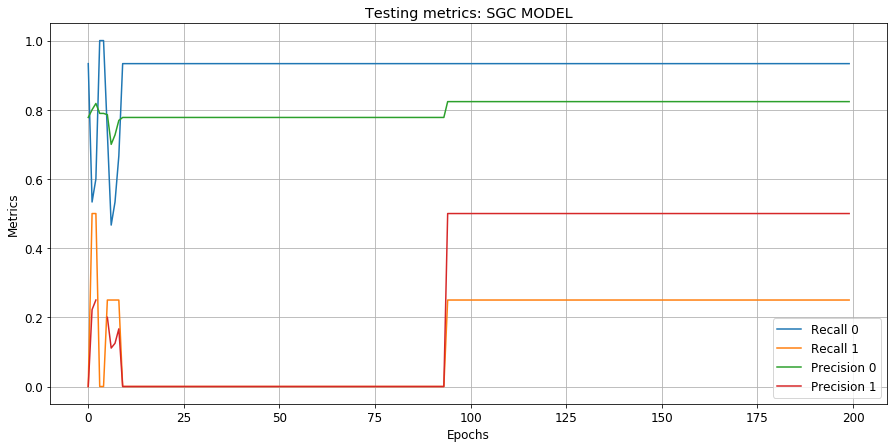

In [203]:
plt.figure(figsize=(15,7))
n = len(recall_class_0)
x_axis = range(n)
plt.plot(x_axis,recall_class_0, label = 'Recall 0'  )
plt.plot(x_axis,recall_class_1, label = 'Recall 1'  )
plt.plot(x_axis,precision_class_0, label = 'Precision 0'  )
plt.plot(x_axis,precision_class_1, label = 'Precision 1'  )
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Testing metrics: SGC MODEL')
plt.legend()
plt.grid()
plt.savefig(PLOT_DIRECTORY + 'Test_recall_precision: model SGC: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

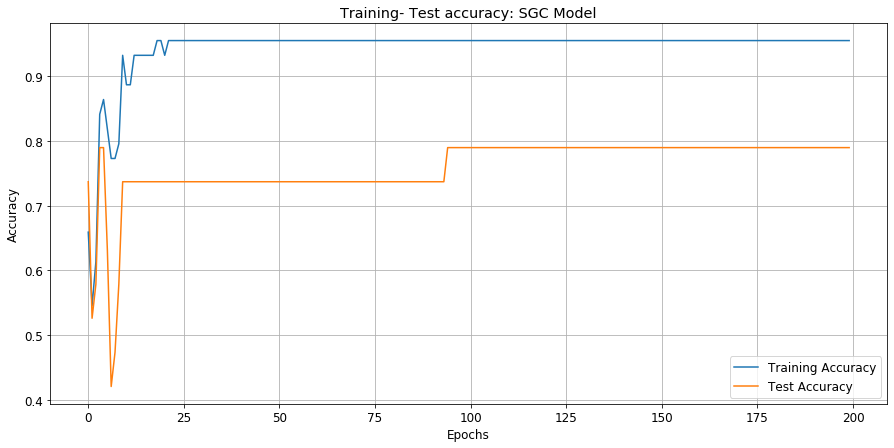

In [204]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),Train_accuracy[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: SGC Model' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model SGC: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')

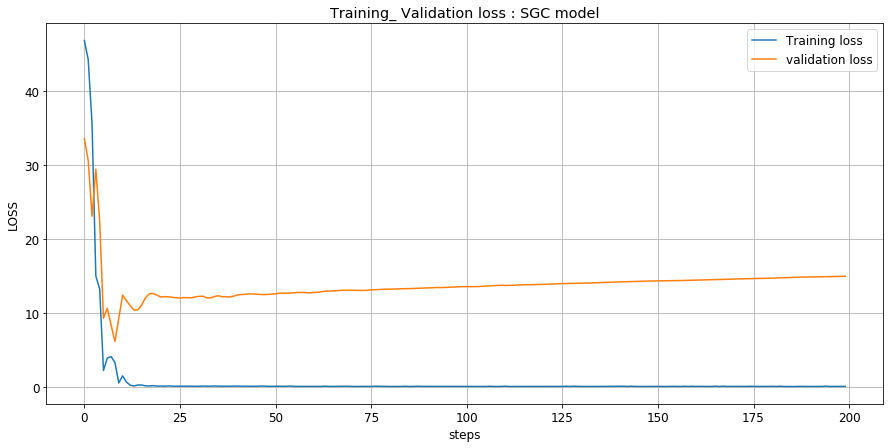

In [205]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),LOSS_epoch[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch[:], label= 'validation loss' )
plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training_ Validation loss : SGC model' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model SGC: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

In [207]:
N_FOLDS = 9
Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)




WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)


TRAIN_ACC_BOXPLOT = []
TEST_ACC_BOXPLOT = []
RECALL_1_BOXPLOT = []
RECALL_0_BOXPLOT = []
PRECISION_1_BOXPLOT = []
PRECISION_0_BOXPLOT = []
CONVERGED_TRAINING_LOSS = []
CONVERGED_VALID_LOSS = []


for step in range(N_FOLDS):
    
    print('Fold : ',step)
 
    model = SGC(hidden_channels=BATCH_SIZE,K=K).double()
    criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
    opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)
    opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)
    optimizer = opt_1
    
    train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
    train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

    train_indicies = train_indicies_class_1 + train_indicies_class_0
    test_indicies = test_indicies_class_1 + test_indicies_class_0 

    train_dataset = [patients_dataset[i] for i in train_indicies] 
    test_dataset = [patients_dataset[i] for i in test_indicies]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 
    
  
    
    LOSS_epoch = []
    TOTAL_LOSS = []
    TEST_epoch = []
    recall_class_0 =[]
    precision_class_0 =[]
    recall_class_1 =[]
    precision_class_1 =[]

    Train_accuracy = []
    Test_accuracy = []


    for epoch in range(1, 201):
        loss = train()
        test_loss = valid()
        #print(loss)
        TOTAL_LOSS = TOTAL_LOSS + loss
        LOSS_epoch.append(np.mean(loss))
        TEST_epoch.append(np.mean(test_loss))
        train_acc = test(train_loader)[0]
        #print('test')
        test_acc = test(test_loader)[0]
        recall_1 = test(test_loader)[2]
        precision_1 = test(test_loader)[1]
        precision_0 = test(test_loader)[3]
        recall_0 = test(test_loader)[4]
    
        recall_class_0.append(recall_0)
        recall_class_1.append(recall_1)
    
        precision_class_0.append(precision_0)
        precision_class_1.append(precision_1)
   
        Train_accuracy.append(train_acc)
        Test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
        
    TRAIN_ACC_BOXPLOT.append(train_acc)
    TEST_ACC_BOXPLOT.append(test_acc)
    RECALL_1_BOXPLOT.append(recall_1)
    RECALL_0_BOXPLOT.append(recall_0)
    PRECISION_1_BOXPLOT.append(precision_1)
    PRECISION_0_BOXPLOT.append(precision_0)
    CONVERGED_TRAINING_LOSS.append(np.mean(loss))
    CONVERGED_VALID_LOSS.append(np.mean(test_loss)) 

Fold :  0
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.2500, recall_1: 0.2500,precision_0: 0.8000,recall_0: 0.8000
Fold :  1
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.4000, recall_1: 0.5000,precision_0: 0.8571,recall_0: 0.8000
Fold :  2


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 0.8636, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
Fold :  3
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
Fold :  4
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.2222, recall_1: 0.5000,precision_0: 0.8000,recall_0: 0.5333
Fold :  5
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.3333, recall_1: 0.2500,precision_0: 0.8125,recall_0: 0.8667
Fold :  6
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
Fold :  7
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
Fold :  8


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 0.7273, Test Acc: 0.3158, precision_1: 0.1538, recall_1: 0.5000,precision_0: 0.6667,recall_0: 0.2667


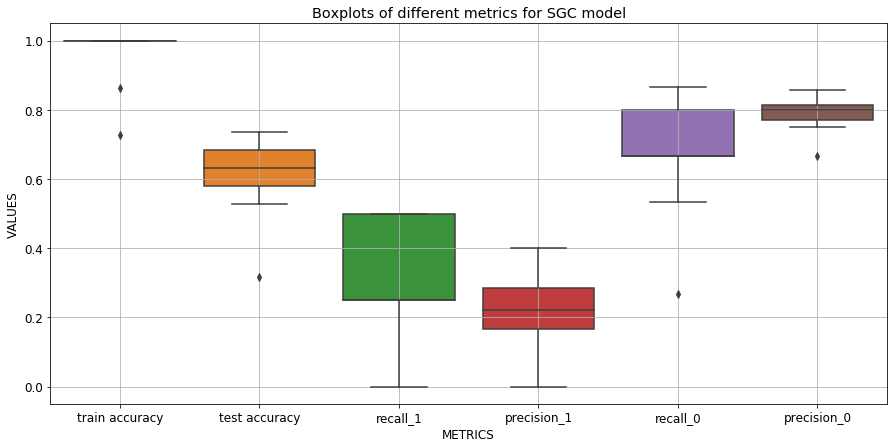

In [209]:
losses_SGC = pd.DataFrame({},columns =['training_loss', 'validation_loss'])
losses_SGC['training_loss'] = CONVERGED_TRAINING_LOSS
losses_SGC['validation_loss'] = CONVERGED_VALID_LOSS


metrics_SGC = pd.DataFrame({},columns =['train accuracy', 'test accuracy', 'recall_1', 'precision_1', 'recall_0','precision_0'])
metrics_SGC['train accuracy'] = TRAIN_ACC_BOXPLOT
metrics_SGC['test accuracy'] = TEST_ACC_BOXPLOT
metrics_SGC['recall_1'] = RECALL_1_BOXPLOT
metrics_SGC['recall_0'] = RECALL_0_BOXPLOT
metrics_SGC['precision_1'] = PRECISION_1_BOXPLOT
metrics_SGC['precision_0'] = PRECISION_0_BOXPLOT

plt.figure(figsize=(15,7))
sns.boxplot(data=metrics_SGC)
plt.xlabel('METRICS')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for SGC model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS METRICS SGC: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

## SAGEConv

$$
\mathbf{x}_{i}^{\prime}=\mathbf{W}_{1} \mathbf{x}_{i}+\mathbf{W}_{2} \cdot \operatorname{mean}_{j \in \mathcal{N}(i)} \mathbf{x}_{j}
$$
PARAMETERS:
- in_channels (int or tuple) - Size of each input sample. A tuple corresponds to the sizes of source and target dimensionalities.
- out_channels (int) - Size of each output sample.
- normalize (bool, optional) - If set to True, output features will be $\ell_{2}$ normalized, i.e., $\frac{\mathbf{x}_{i}^{\prime}}{\left\|\mathbf{x}_{i}^{\prime}\right\|_{2}}$. (default: False)
- root_weight (bool, optional) - If set to False, the layer will not add transformed root node features to the output. (default: True )
- bias (bool, optional) - If set to False, the layer will not learn an additive bias. (default: True)
$=^{* *} \mathrm{kwargs}$ (optional) - Additional arguments of torch_geometric.nn. conv.MessagePassing.

In [327]:
from torch_geometric.nn import SAGEConv


class SAGE(nn.Module):
    def __init__(self,hidden_channels,normalize = True):
        super(SAGE, self).__init__()
        self.gc1 = SAGEConv(64, hidden_channels,normalize=normalize)
        self.gc2 = SAGEConv(hidden_channels, hidden_channels,normalize=normalize)
        self.lin = Linear(hidden_channels, 2)

    def reset_parameters(self):
        self.gc1.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gc1(x, edge_index)
        x= F.relu(x)
        x = self.gc2(x, edge_index)
        x= F.relu(x)
            
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1)
    
    

In [328]:
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#wandb.init(project='oncology-project')

Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 2
K = 2




model = SAGE(hidden_channels=BATCH_SIZE).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1


WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
#criterion = FocalLoss(GAMMA,ALPHA)

LOSS_epoch_SAGE = []
TOTAL_LOSS = []
TEST_epoch = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy = []
Test_accuracy = []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch_SAGE.append(np.mean(loss))
    TEST_epoch.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy.append(train_acc)
    Test_accuracy.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    

[0.6449393377132521, 0.6945098552639926, 0.7551160749764214, 0.6073118671543317, 0.5382247929731607]
test
Epoch: 001, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.6305288811216373, 0.7214460815122353, 0.5750349907479113, 0.6394630519252149, 0.6475205240746101]
test


invalid value encountered in long_scalars


Epoch: 002, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.6283236447151687, 0.6140414850010525, 0.5411462161538659, 0.5694482360461001, 0.8917072329449053]
test
Epoch: 003, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.6541971644508151, 0.7161646054231908, 0.563912001841659, 0.5397038085380973, 0.4116554333613371]
test
Epoch: 004, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.5339385272558135, 0.694046934961353, 0.44778648751217814, 0.5470364257148963, 0.657432223615152]
test
Epoch: 005, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.4613002975223856, 0.510623923477298, 0.7166375841034187, 0.4856469155442152, 0.5989887069609154]
test
Epoch: 006, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0

test
Epoch: 039, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.030332127210906914, 0.037042620478729235, 0.07245953674551492, 0.036786720027466635, 0.05183571249730232]
test
Epoch: 040, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.04300823760619627, 0.020992148113447615, 0.06781479001699696, 0.027607786101989953, 0.014125282044875991]
test
Epoch: 041, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.03875829584778687, 0.03797852622788252, 0.01920116207278043, 0.031018896891292058, 0.07936519157103364]
test
Epoch: 042, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.022334669864489804, 0.04005891150940905, 0.056257900090434146, 0.025116125476515733, 0.009378033893955279]
test
Epoch: 043, Train Acc: 1.0000, Test Acc: 0.5

Epoch: 074, Train Acc: 0.9545, Test Acc: 0.6842, precision_1: 0.3750, recall_1: 0.7500,precision_0: 0.9091,recall_0: 0.6667
[0.094090527923469, 0.2145265125683121, 0.056268113549646594, 0.028689937223112905, 0.08136882921075542]
test
Epoch: 075, Train Acc: 0.9773, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[0.2137443426062873, 0.10302955703761123, 0.012750841410803664, 0.044515482799569635, 0.01856188069439715]
test
Epoch: 076, Train Acc: 0.9773, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.04348487818480477, 0.032022037372283034, 0.16383659876593853, 0.09803271760990638, 0.0460440936233375]
test
Epoch: 077, Train Acc: 0.9773, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.04680905713923079, 0.038605814474735774, 0.1108495449689789, 0.06937050924435309, 0.03409271052999934]
test
Epoch: 078, Train Acc: 1.0000, Test Acc: 0.6316, precision_1

test
Epoch: 109, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.007878581802907335, 0.00954078020745103, 0.008611864970955603, 0.00927176901564303, 0.0014104235012861123]
test
Epoch: 110, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.007182068935048606, 0.009266135724586988, 0.009537968715909879, 0.006458845401147073, 0.007408145650588278]
test
Epoch: 111, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.009790087300901319, 0.00703214409123739, 0.007577001305931947, 0.007600789070722123, 0.005035435606457071]
test
Epoch: 112, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.008851895633867573, 0.008932051079151477, 0.005209523154525708, 0.007669330872895426, 0.006282567701262162]
test
Epoch: 113, Train Acc: 1.0000, Test A

test
Epoch: 145, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.002781061887548191, 0.006775984731882752, 0.00481274207470261, 0.001860703363669883, 0.007997858534806182]
test
Epoch: 146, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.004439105924056929, 0.003651522668445937, 0.007184718434521263, 0.0028492640607889167, 0.004272025168069488]
test
Epoch: 147, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.004417807233083461, 0.005932059076773421, 0.005155138780009222, 0.0025211749654793785, 0.004092163256729041]
test
Epoch: 148, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.0059712763930645195, 0.004931747214611001, 0.004986708552580958, 0.002895030971737479, 0.0011310910118646595]
test
Epoch: 149, Train Acc: 1.0000, T

test
Epoch: 179, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.003044792842984189, 0.0037099541781405935, 0.0032209281118267073, 0.0031194696092618737, 0.0012580251685254554]
test
Epoch: 180, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.002132616449633379, 0.0031826546600503456, 0.0017556014589112786, 0.004005237102607869, 0.005091746436282771]
test
Epoch: 181, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.1667, recall_1: 0.2500,precision_0: 0.7692,recall_0: 0.6667
[0.003634934243001556, 0.0010882420816347663, 0.003927751386795477, 0.0031554535525540202, 0.0029161587049353717]
test
Epoch: 182, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.002439079544659996, 0.003374454158515208, 0.0037405852912392634, 0.0032199190688154025, 0.0008348282905227568]
test
Epoch: 183, Train Acc: 

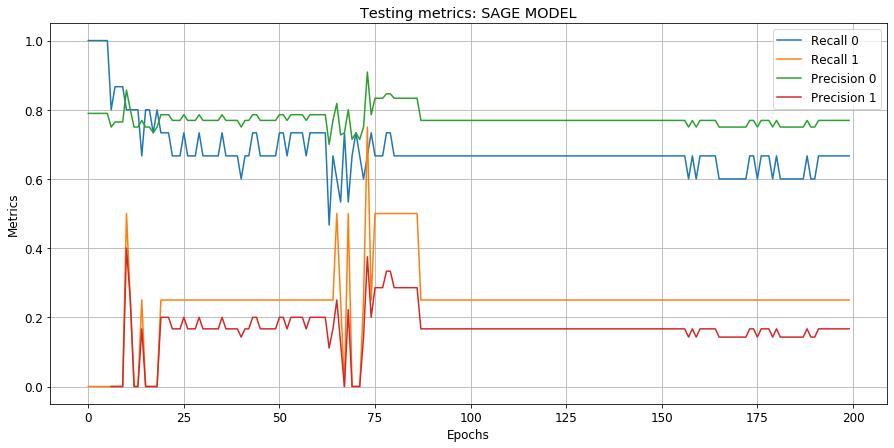

In [329]:
plt.figure(figsize=(15,7))
n = len(recall_class_0)
x_axis = range(n)
plt.plot(x_axis,recall_class_0, label = 'Recall 0'  )
plt.plot(x_axis,recall_class_1, label = 'Recall 1'  )
plt.plot(x_axis,precision_class_0, label = 'Precision 0'  )
plt.plot(x_axis,precision_class_1, label = 'Precision 1'  )
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Testing metrics: SAGE MODEL')
plt.legend()
plt.grid()
plt.savefig(PLOT_DIRECTORY + 'Test_recall_precision: model SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

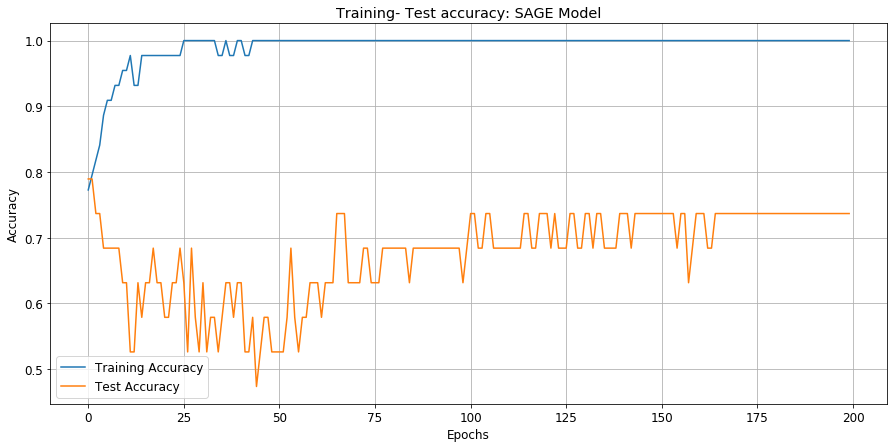

In [303]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_SAGE)
plt.plot(range(n),Train_accuracy[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: SAGE Model' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')

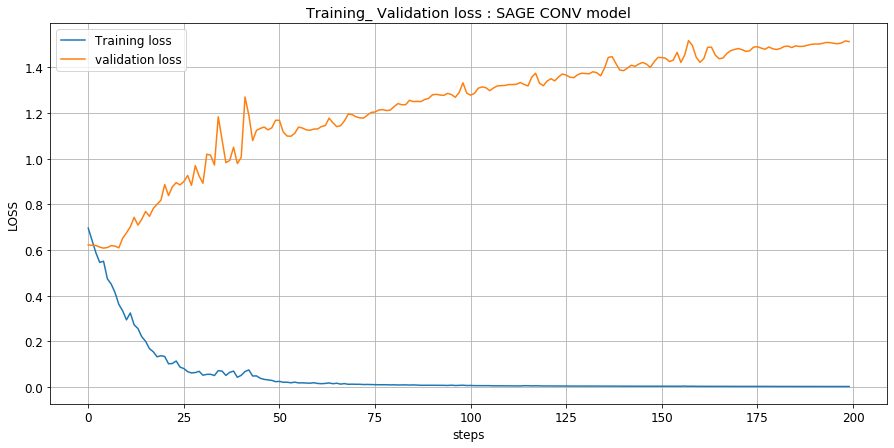

In [305]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch)
plt.plot(range(n),LOSS_epoch_SAGE[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch[:], label= 'validation loss' )
plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training_ Validation loss : SAGE CONV model' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

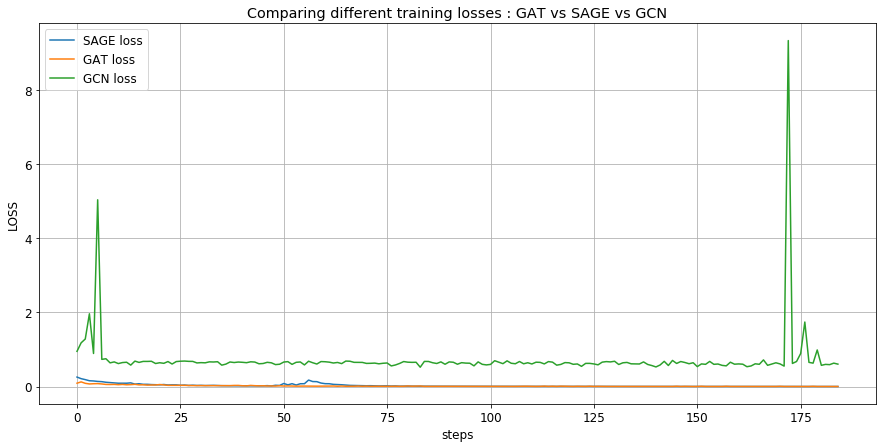

In [339]:
plt.figure(figsize=(15,7))
a=15

n = len(LOSS_epoch)-a
plt.plot(range(n),LOSS_epoch_SAGE[a:],label= 'SAGE loss'   )
plt.plot(range(n),LOSS_epoch_GAT[a:], label= 'GAT loss' )
plt.plot(range(n),LOSS_epoch_GCN[a:], label= 'GCN loss' )

plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Comparing different training losses : GAT vs SAGE vs GCN' )
plt.savefig(PLOT_DIRECTORY + 'Comparaison Training losses GAT vs SAGE Vs GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

In [401]:
N_FOLDS = 10
Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)




WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)


TRAIN_ACC_BOXPLOT = []
TEST_ACC_BOXPLOT = []
RECALL_1_BOXPLOT = []
RECALL_0_BOXPLOT = []
PRECISION_1_BOXPLOT = []
PRECISION_0_BOXPLOT = []
CONVERGED_TRAINING_LOSS = []
CONVERGED_VALID_LOSS = []


for step in range(N_FOLDS):
    
    print('Fold : ',step)
 
    model = SAGE(hidden_channels=BATCH_SIZE).double()

    criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)
    opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)
    opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)
    optimizer = opt_1
    
    train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
    train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

    train_indicies = train_indicies_class_1 + train_indicies_class_0
    test_indicies = test_indicies_class_1 + test_indicies_class_0 

    train_dataset = [patients_dataset[i] for i in train_indicies] 
    test_dataset = [patients_dataset[i] for i in test_indicies]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 
    
  
    
    LOSS_epoch = []
    TOTAL_LOSS = []
    TEST_epoch = []
    recall_class_0 =[]
    precision_class_0 =[]
    recall_class_1 =[]
    precision_class_1 =[]

    Train_accuracy = []
    Test_accuracy = []


    for epoch in range(1, 201):
        loss = train()
        test_loss = valid()
        #print(loss)
        TOTAL_LOSS = TOTAL_LOSS + loss
        LOSS_epoch.append(np.mean(loss))
        TEST_epoch.append(np.mean(test_loss))
        train_acc = test(train_loader)[0]
        #print('test')
        test_acc = test(test_loader)[0]
        recall_1 = test(test_loader)[2]
        precision_1 = test(test_loader)[1]
        precision_0 = test(test_loader)[3]
        recall_0 = test(test_loader)[4]
    
        recall_class_0.append(recall_0)
        recall_class_1.append(recall_1)
    
        precision_class_0.append(precision_0)
        precision_class_1.append(precision_1)
   
        Train_accuracy.append(train_acc)
        Test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
        
    TRAIN_ACC_BOXPLOT.append(train_acc)
    TEST_ACC_BOXPLOT.append(test_acc)
    RECALL_1_BOXPLOT.append(recall_1)
    RECALL_0_BOXPLOT.append(recall_0)
    PRECISION_1_BOXPLOT.append(precision_1)
    PRECISION_0_BOXPLOT.append(precision_0)
    CONVERGED_TRAINING_LOSS.append(np.mean(loss))
    CONVERGED_VALID_LOSS.append(np.mean(test_loss)) 

Fold :  0
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
Fold :  1


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.5000,precision_0: 0.8667,recall_0: 0.8667
Fold :  2
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.4737, precision_1: 0.1250, recall_1: 0.2500,precision_0: 0.7273,recall_0: 0.5333
Fold :  3


invalid value encountered in long_scalars


Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7778,recall_0: 0.9333
Fold :  4
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.3333, recall_1: 0.2500,precision_0: 0.8125,recall_0: 0.8667
Fold :  5
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
Fold :  6
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.5789, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7333,recall_0: 0.7333
Fold :  7
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.7368, precision_1: 0.3333, recall_1: 0.2500,precision_0: 0.8125,recall_0: 0.8667
Fold :  8
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7647,recall_0: 0.8667
Fold :  9
Epoch: 200, Train Acc: 1.0000, Test Acc: 0.4737, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.6923,recall_0: 0.6000


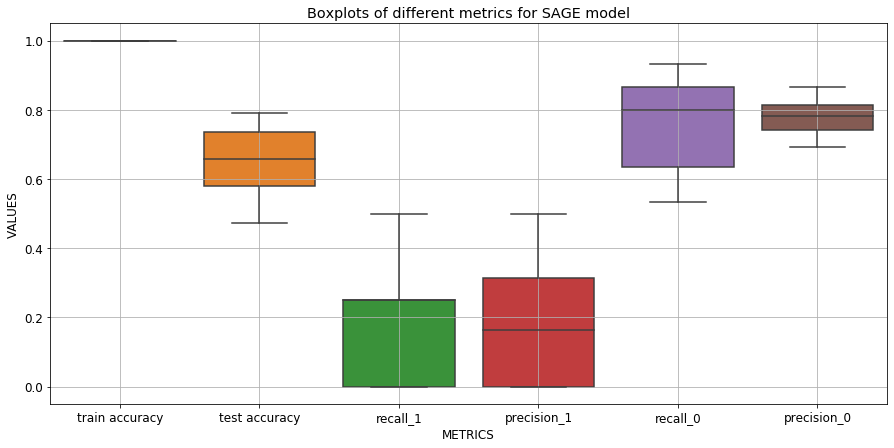

In [403]:
losses_SAGE = pd.DataFrame({},columns =['training_loss', 'validation_loss'])
losses_SAGE['training_loss'] = CONVERGED_TRAINING_LOSS
losses_SAGE['validation_loss'] = CONVERGED_VALID_LOSS


metrics_SAGE = pd.DataFrame({},columns =['train accuracy', 'test accuracy', 'recall_1', 'precision_1', 'recall_0','precision_0'])
metrics_SAGE['train accuracy'] = TRAIN_ACC_BOXPLOT
metrics_SAGE['test accuracy'] = TEST_ACC_BOXPLOT
metrics_SAGE['recall_1'] = RECALL_1_BOXPLOT
metrics_SAGE['recall_0'] = RECALL_0_BOXPLOT
metrics_SAGE['precision_1'] = PRECISION_1_BOXPLOT
metrics_SAGE['precision_0'] = PRECISION_0_BOXPLOT

metrics_SAGE.to_csv('./data/output/metrics/SAGE.csv', index=False)


plt.figure(figsize=(15,7))
sns.boxplot(data=metrics_SAGE)
plt.xlabel('METRICS')
plt.ylabel('VALUES')
plt.grid()
plt.title( 'Boxplots of different metrics for SAGE model' )
plt.savefig(PLOT_DIRECTORY + 'BOXPLOTS METRICS SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

## Comparing loss function on the same split

In [369]:
BATCH_SIZE = 10


index_class_1 = list(labels_df[labels_df.label == 1].index)
index_class_0 = list(labels_df[labels_df.label == 0].index)

train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)

train_indicies = train_indicies_class_1 + train_indicies_class_0
test_indicies = test_indicies_class_1 + test_indicies_class_0 

train_dataset = [patients_dataset[i] for i in train_indicies] 
test_dataset = [patients_dataset[i] for i in test_indicies]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#wandb.init(project='oncology-project')

Learning_rate = 0.01
IN_CHANNELS = 64
HIDDEN_CHANNELS = BATCH_SIZE
N_CLASSES = 2
DROPOUT = 0
CLASS_1_WEIGHT = 3





WEIGHTS = torch.FloatTensor([1,CLASS_1_WEIGHT]).double()
criterion = torch.nn.CrossEntropyLoss(weight = WEIGHTS)

In [370]:
model = GCN(IN_CHANNELS,HIDDEN_CHANNELS,N_CLASSES, DROPOUT).double()
opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1
LOSS_epoch_GCN = []
TOTAL_LOSS = []
TEST_epoch_GCN = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy_GCN = []
Test_accuracy_GCN = []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch_GCN.append(np.mean(loss))
    TEST_epoch_GCN.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy_GCN.append(train_acc)
    Test_accuracy_GCN.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    
    

[93.91566766957288, 1128.5718229218992, 42.60726098924609, 160.12346244051162, 862.544409296503]
test
Epoch: 001, Train Acc: 0.4773, Test Acc: 0.4211, precision_1: 0.1818, recall_1: 0.5000,precision_0: 0.7500,recall_0: 0.4000
[0.991715703745693, 115.48624887353675, 522.0725551220322, 17.86215595135846, 0.26695639768748614]
test
Epoch: 002, Train Acc: 0.5227, Test Acc: 0.4737, precision_1: 0.2000, recall_1: 0.5000,precision_0: 0.7778,recall_0: 0.4667
[0.4019007417333427, 389.0041778011033, 166.75361536443765, 404.53729600067345, 50.65540378086575]
test
Epoch: 003, Train Acc: 0.6818, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[148.50848361795136, 104.778596697801, 3.4237052332177855, 4.595080276998396, 12.636975986489114]
test
Epoch: 004, Train Acc: 0.7727, Test Acc: 0.6316, precision_1: 0.2000, recall_1: 0.2500,precision_0: 0.7857,recall_0: 0.7333
[1.7068965528089914, 0.5786960149125484, 1.4750887579095906, 5.769666199921831, 7.815541157

[0.6715910141105721, 0.6829095768484386, 0.6604217241451109, 0.5202261633068044, 0.713501442801913]
test
Epoch: 038, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.6909257218486763, 0.6877836812979441, 0.5301711212533352, 0.6829092753667938, 0.42099332049163574]
test
Epoch: 039, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.5605504981888484, 0.6478662967746518, 1.3480720414042593, 0.6427425838745746, 0.7786387951436968]
test
Epoch: 040, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.587798776035747, 0.6380631441520819, 0.6873722994033061, 0.7231689154807965, 0.713409499697284]
test
Epoch: 041, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.6826125754734552, 0.682910553933852, 0.5885265931992611, 0.694898767776061, 0.7

Epoch: 074, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.7269896597231233, 0.7249652179748938, 0.6270242642093482, 0.6438525093835091, 0.7055704857784416]
test
Epoch: 075, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.7253475576491157, 0.49805734837802057, 0.7252178244116176, 0.6360460102034589, 0.6141079366220746]
test
Epoch: 076, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.5174921811513739, 0.7272667413505888, 0.6829786354597138, 0.6214952040270034, 0.7050562661493003]
test
Epoch: 077, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.4988635961568294, 0.545549484473094, 0.6898459791443375, 0.6874223328068139, 0.7047802032524851]
test
Epoch: 078, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 

test
Epoch: 112, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.6502407777416443, 0.6207839420191982, 0.6844247334232614, 0.7050810385853034, 0.8144794201827399]
test
Epoch: 113, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.41711031830625855, 0.6482656454042666, 0.7542131414568185, 0.48780091797544173, 0.7255961373770196]
test
Epoch: 114, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.7859031692785751, 0.6846355893325807, 0.662827749221814, 0.6131030542546991, 0.3857428966455483]
test
Epoch: 115, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.811989842049573, 0.6819085387499503, 0.6143313850406541, 0.571431679048004, 0.7218246644329058]
test
Epoch: 116, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall

Epoch: 149, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.5017512276277085, 0.5666259237652292, 0.4945343155246976, 0.818391526312203, 0.46088811964783927]
test
Epoch: 150, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.6303477788997045, 0.7599706238767736, 0.6830240519502225, 0.5644170223581607, 0.49852810698314753]
test
Epoch: 151, Train Acc: 0.8409, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.7315060199964181, 0.5672077843482628, 0.7259934406913018, 0.6259165824564068, 0.5456147926772495]
test
Epoch: 152, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.6830803090485992, 0.727213610251976, 0.6444973235629755, 0.6062891297799021, 0.7070386520057919]
test
Epoch: 153, Train Acc: 0.8182, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 

[0.46278076371433496, 0.6829426388957999, 0.7521413484281809, 0.5880628154057445, 0.2852609887665493]
test
Epoch: 187, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7647,recall_0: 0.8667
[0.6357205770088054, 0.6353285893384851, 0.6078414936561116, 0.5032453176876824, 0.7009757175972726]
test
Epoch: 188, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7647,recall_0: 0.8667
[0.5652984997110089, 0.6729087035091126, 0.7203761758251722, 0.749634054271153, 0.5635719584564436]
test
Epoch: 189, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7647,recall_0: 0.8667
[0.6689108371702487, 0.5855924068795945, 0.4243932091077403, 0.752591908388079, 0.7069104468724596]
test
Epoch: 190, Train Acc: 0.8182, Test Acc: 0.6842, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7647,recall_0: 0.8667
[0.6126160467679682, 0.537192748390015, 0.682909896550071, 0.6843065522876108, 0.

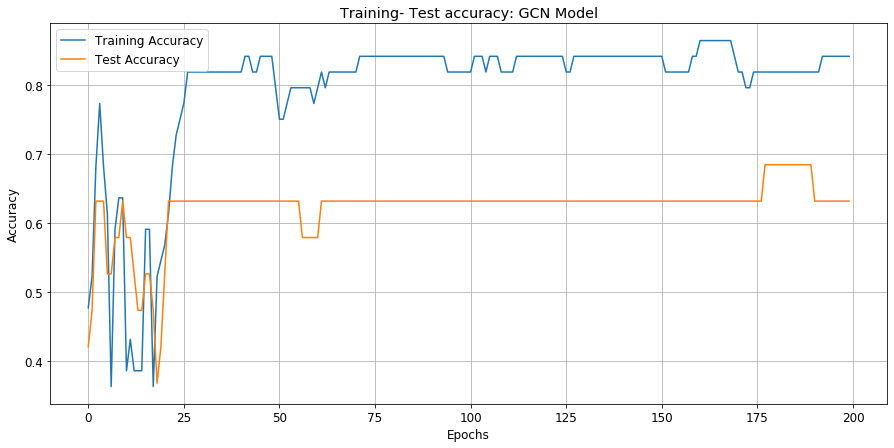

In [371]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_GCN)
plt.plot(range(n),Train_accuracy_GCN[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy_GCN[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: GCN Model' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')

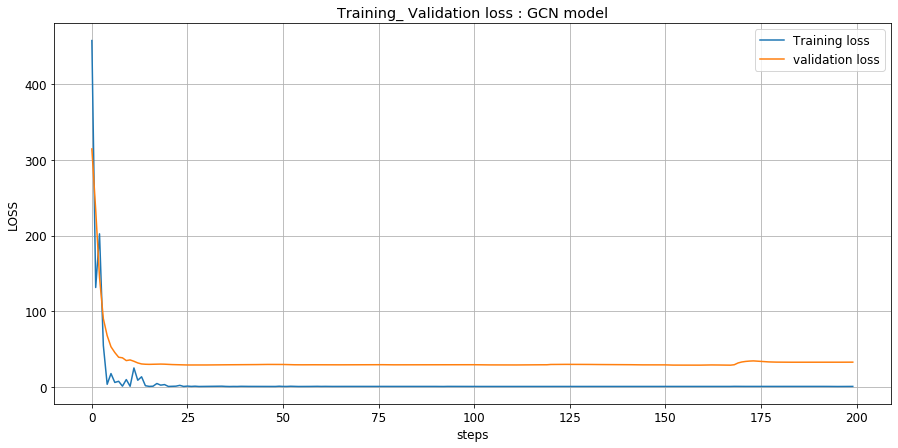

In [372]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_GCN)
plt.plot(range(n),LOSS_epoch_GCN[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch_GCN[:], label= 'validation loss' )
plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training_ Validation loss : GCN model' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

In [378]:
model = GAT( hidden_channels =BATCH_SIZE, out_channels =2,first_heads=8, output_heads=1, dropout=DROPOUT).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1


LOSS_epoch_GAT = []
TOTAL_LOSS = []
TEST_epoch_GAT = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy_GAT = []
Test_accuracy_GAT = []


for epoch in range(1, 201):
    loss = train()
    test_loss_GAT = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch_GAT.append(np.mean(loss))
    TEST_epoch_GAT.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy_GAT.append(train_acc)
    Test_accuracy_GAT.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    
    

[79.64469532239089, 258.3365959023358, 657.5516773590707, 262.91181724641336, 252.52915887668095]
test
Epoch: 001, Train Acc: 0.4091, Test Acc: 0.3684, precision_1: 0.2500, recall_1: 1.0000,precision_0: 1.0000,recall_0: 0.2000
[198.63617805479626, 49.17721006942335, 173.37463566268684, 67.35963892916074, 151.77689357993276]
test
Epoch: 002, Train Acc: 0.7955, Test Acc: 0.6316, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7500,recall_0: 0.8000
[0.8546917192398098, 27.71488357844936, 110.85439354346343, 115.21687132867545, 7.771561172376091e-16]
test
Epoch: 003, Train Acc: 0.8864, Test Acc: 0.6842, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7647,recall_0: 0.8667
[19.56089956750904, 23.97093979956135, 34.91244110201302, 1.7582968359271562, 11.206136669537862]
test
Epoch: 004, Train Acc: 0.8864, Test Acc: 0.7368, precision_1: 0.3333, recall_1: 0.2500,precision_0: 0.8125,recall_0: 0.8667
[1.8568232413963304, 0.2789255815243303, 8.6207528056783, 7.893898237685983, 1.3459360

[0.14430884507113226, 0.18002926255870957, 0.0010072706852661166, 0.0011641234434056488, 2.088725452435038e-06]
test
Epoch: 036, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.034468305384841566, 0.0011761792482215254, 0.09517470292913027, 0.11406904915134139, 1.0761384167180825e-05]
test
Epoch: 037, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.10022234448741338, 0.007977805703806125, 0.0010893858397914423, 0.029534039105681986, 0.25908681508438863]
test
Epoch: 038, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.11697788286664605, 0.13233907204102133, 0.0010486518121555685, 0.03420920177620314, 3.924538888616274e-06]
test
Epoch: 039, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.029291842097402588, 0.000827968369985

[0.00038533864646707463, 0.057654743485079055, 0.0007691905526354269, 0.0726428173180728, 0.0002935155411667211]
test
Epoch: 071, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[2.118217432646322e-05, 0.05041185356744569, 0.020044117049707044, 0.06318006996119621, 0.0006053716393156562]
test
Epoch: 072, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.06405189845514919, 0.00016357454022560033, 0.07283359547960862, 0.0001937528165821089, 0.06815841412117116]
test
Epoch: 073, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[8.81885812530622e-05, 0.01575310823082917, 0.0008576173963688843, 0.10898121987035056, 0.0002058160609792929]
test
Epoch: 074, Train Acc: 1.0000, Test Acc: 0.6316, precision_1: 0.2857, recall_1: 0.5000,precision_0: 0.8333,recall_0: 0.6667
[0.0005687317633850268, 0.076742330012

[6.933688991464529e-05, 0.03947578515775243, 0.00024252923436669368, 0.044860641143458405, 0.00012358487701633015]
test
Epoch: 105, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[0.00018769425367318865, 0.03899352541826199, 0.030192736661805584, 0.0055759602731759875, 0.0001912699231745133]
test
Epoch: 106, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[0.0001555556983478655, 4.5596306494517464e-05, 0.007698511525062179, 0.03355735677281782, 0.0889278004916957]
test
Epoch: 107, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[1.8518099947911087e-05, 0.037710696456988234, 0.00011242839409113168, 0.044124906851160196, 0.00014994020680254605]
test
Epoch: 108, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[0.00010499405099406831, 0.

[0.02224495842014208, 0.0022036147045537127, 0.02198836102488711, 1.0084387170169404e-05, 5.248202566582726e-05]
test
Epoch: 139, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[6.829558156119316e-05, 3.4170341615595715e-05, 0.02096265876592183, 0.019402791263477347, 7.628746875469326e-05]
test
Epoch: 140, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[0.024844366703091626, 7.588271130223699e-06, 3.544232098213976e-05, 0.017222491406675734, 0.004845608306005191]
test
Epoch: 141, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[0.0008704729842063343, 0.024391535001771835, 2.823302566977474e-05, 0.0024360224245265245, 0.03400629570050465]
test
Epoch: 142, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[0.02422868317592428, 0.0378458

[0.019384904780934985, 0.017577501233884463, 1.659940432370066e-05, 5.486623783385986e-05, 2.0171899558643994e-07]
test
Epoch: 173, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[5.8043003454319526e-05, 0.002333898311450363, 6.860629979167075e-05, 0.017344366330158248, 0.03028513517541013]
test
Epoch: 174, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[1.1210449549450621e-05, 9.311595450686818e-05, 0.013431978946356449, 0.018766858403280007, 5.418352604780139e-06]
test
Epoch: 175, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[0.014944782761101071, 0.01711188160626164, 0.0013923275440141272, 7.834906260414918e-05, 2.9387850827216923e-07]
test
Epoch: 176, Train Acc: 1.0000, Test Acc: 0.6842, precision_1: 0.3333, recall_1: 0.5000,precision_0: 0.8462,recall_0: 0.7333
[0.014850507703132189, 0.01

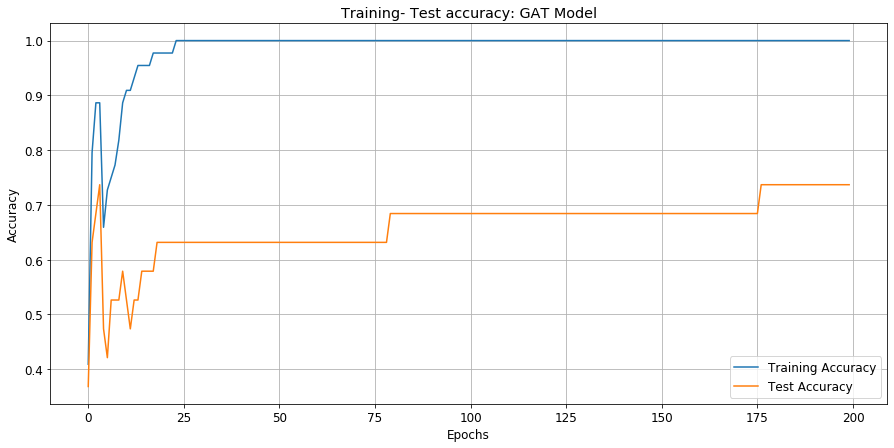

In [379]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_GAT)
plt.plot(range(n),Train_accuracy_GAT[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy_GAT[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: GAT Model' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')

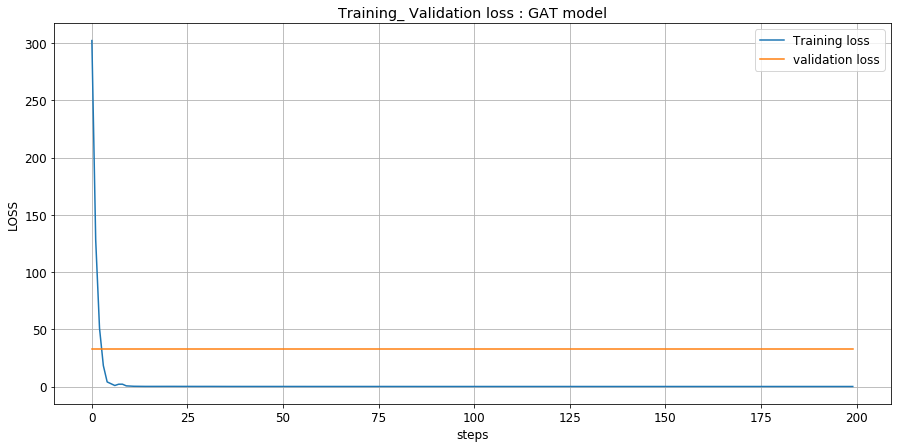

In [380]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_GAT)
plt.plot(range(n),LOSS_epoch_GAT[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch_GAT[:], label= 'validation loss' )
plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training_ Validation loss : GAT model' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model GAT: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

In [381]:
model = SAGE(hidden_channels=BATCH_SIZE).double()

opt_1 = torch.optim.Adam(model.parameters(), lr=Learning_rate)

opt_2 = torch.optim.SGD(model.parameters(), lr=Learning_rate, momentum = 0.9)

optimizer = opt_1

LOSS_epoch_SAGE = []
TOTAL_LOSS = []
TEST_epoch_SAGE = []
recall_class_0 =[]
precision_class_0 =[]
recall_class_1 =[]
precision_class_1 =[]

Train_accuracy_SAGE = []
Test_accuracy_SAGE= []


for epoch in range(1, 201):
    loss = train()
    test_loss = valid()
    print(loss)
    TOTAL_LOSS = TOTAL_LOSS + loss
    LOSS_epoch_SAGE.append(np.mean(loss))
    TEST_epoch_SAGE.append(np.mean(test_loss))
    train_acc = test(train_loader)[0]
    print('test')
    test_acc = test(test_loader)[0]
    recall_1 = test(test_loader)[2]
    precision_1 = test(test_loader)[1]
    precision_0 = test(test_loader)[3]
    recall_0 = test(test_loader)[4]
    
    recall_class_0.append(recall_0)
    recall_class_1.append(recall_1)
    
    precision_class_0.append(precision_0)
    precision_class_1.append(precision_1)
   
    Train_accuracy_SAGE.append(train_acc)
    Test_accuracy_SAGE.append(test_acc)



    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, precision_1: {precision_1:.4f}, recall_1: {recall_1:.4f},precision_0: {precision_0:.4f},recall_0: {recall_0:.4f}')
    #wandb.log({"loss": np.mean(loss),"Train accuracy": train_acc, "Test acuuracy":test_acc, 'precision_1':precision_1,'recall_1':recall_1,'precision_0': precision_0,'recall_0': recall_0})
    
    

[0.6744709527319668, 0.741767308920111, 0.7208594914020477, 0.6988669409594647, 0.6908171266131191]
test
Epoch: 001, Train Acc: 0.8182, Test Acc: 0.7895, precision_1: 0.5000, recall_1: 0.5000,precision_0: 0.8667,recall_0: 0.8667
[0.6827631868481092, 0.6934407454372568, 0.7030923706431447, 0.6429047971584041, 0.6926716116751296]
test


invalid value encountered in long_scalars


Epoch: 002, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.625436264684276, 0.7188797671359065, 0.683200107966117, 0.6510535817650981, 0.7336083185900114]
test
Epoch: 003, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.5839559074588456, 0.740728504946104, 0.6212105469260965, 0.7185905979763284, 0.567688525833284]
test
Epoch: 004, Train Acc: 0.7727, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.6357352190189351, 0.6482274718801868, 0.7156489814595448, 0.6903203329547231, 0.523851788578233]
test
Epoch: 005, Train Acc: 0.7955, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 0.7895,recall_0: 1.0000
[0.6308024733295102, 0.6440387026481443, 0.7144442773382872, 0.5132113325320576, 0.6630384552114109]
test
Epoch: 006, Train Acc: 0.8182, Test Acc: 0.7895, precision_1: nan, recall_1: 0.0000,precision_0: 

[0.1388088742469134, 0.037055334186605414, 0.02935517476910197, 0.043233318094248366, 0.07094313036269698]
test
Epoch: 039, Train Acc: 0.9773, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[0.06071394950328051, 0.053125574157713434, 0.11974830392539897, 0.05326359372102479, 0.048903944265486506]
test
Epoch: 040, Train Acc: 0.9773, Test Acc: 0.5789, precision_1: 0.2500, recall_1: 0.5000,precision_0: 0.8182,recall_0: 0.6000
[0.06665024989991457, 0.06332957592862007, 0.023824902950257514, 0.07350029455209284, 0.037916012574254865]
test
Epoch: 041, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.06272161471661965, 0.06922145160021209, 0.02079028046901055, 0.05933990451650765, 0.021396517282371817]
test
Epoch: 042, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.02995117933507672, 0.0673686497257305, 0.0416355991

Epoch: 073, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.0183514147904236, 0.009970996161289573, 0.006184694322559203, 0.01227736550761209, 0.0029546315766111443]
test
Epoch: 074, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.00976280413890272, 0.011214295592336939, 0.016549585695551535, 0.010831351666359321, 0.003146650982712835]
test
Epoch: 075, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.012572802696697881, 0.008482384838865178, 0.012399087527654699, 0.013655336296619977, 0.002409278327849453]
test
Epoch: 076, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.1429, recall_1: 0.2500,precision_0: 0.7500,recall_0: 0.6000
[0.010198578417417212, 0.010741890350337124, 0.010170043706260411, 0.013449412821680693, 0.004392464833275366]
test
Epoch: 077, Train Acc: 1.0000, Test Acc: 0.

test
Epoch: 108, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.004856671694432859, 0.005459442285227868, 0.004498006091949774, 0.005852568709295204, 0.004703455589527864]
test
Epoch: 109, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0019430884578837773, 0.005290705934489867, 0.004300008413464366, 0.006012165502053237, 0.007097404230044639]
test
Epoch: 110, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.003131395095276898, 0.005470645969729468, 0.0041396297055923134, 0.005813570149869022, 0.0056601904232567325]
test
Epoch: 111, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.004268509447615822, 0.00551780898206102, 0.005451771963307484, 0.004068794005168867, 0.0038594621308303025]
test
Epoch: 112, Train Acc: 1.0000, T

Epoch: 142, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0037527808260211953, 0.0032491478875805017, 0.0019569846967839245, 0.0030120475690631567, 0.003320977679850564]
test
Epoch: 143, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0037271481172042884, 0.0025602935793163366, 0.002818119990102269, 0.0029126326351476494, 0.003956828919223296]
test
Epoch: 144, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.002752605022986525, 0.002729815194938833, 0.003934605679428537, 0.0012646438063868928, 0.0043002050016301375]
test
Epoch: 145, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0015053256609401018, 0.0037483726674870346, 0.0033160079647816267, 0.0029309046571876743, 0.002699214774326042]
test
Epoch: 146, Train Acc: 1.00

Epoch: 177, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.002152576228542195, 0.002317564911282334, 0.002660389953734582, 0.0014599235280062723, 0.0011045545171542573]
test
Epoch: 178, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0020831249860981576, 0.0021384935315656283, 0.0019372055036073353, 0.0025830577031344115, 0.0010212402311966435]
test
Epoch: 179, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0021281086374298377, 0.001672579668908483, 0.0017224677856104607, 0.002324861064422154, 0.0029319836999241733]
test
Epoch: 180, Train Acc: 1.0000, Test Acc: 0.5263, precision_1: 0.0000, recall_1: 0.0000,precision_0: 0.7143,recall_0: 0.6667
[0.0015128727003583286, 0.0017261930019197215, 0.00276981112966534, 0.0018631157661213034, 0.0024893696245210915]
test
Epoch: 181, Train Acc: 1.00

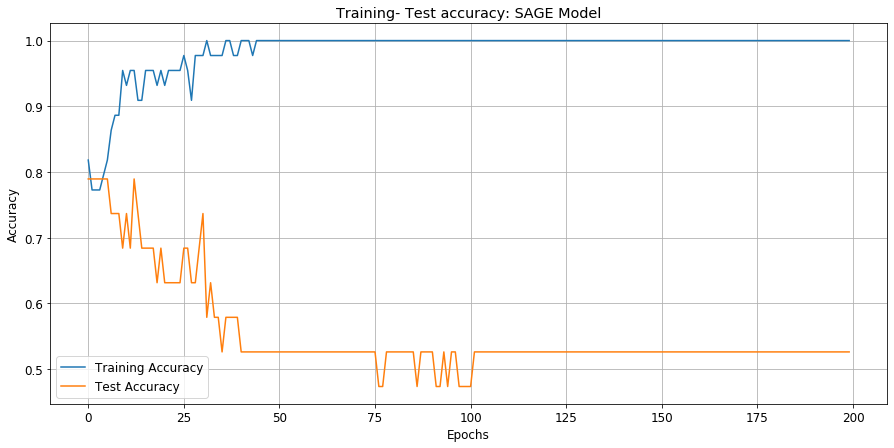

In [382]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_SAGE)
plt.plot(range(n),Train_accuracy_SAGE[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy_SAGE[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: SAGE Model' )
plt.savefig(PLOT_DIRECTORY + 'Train -Test Accuracy: model SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')

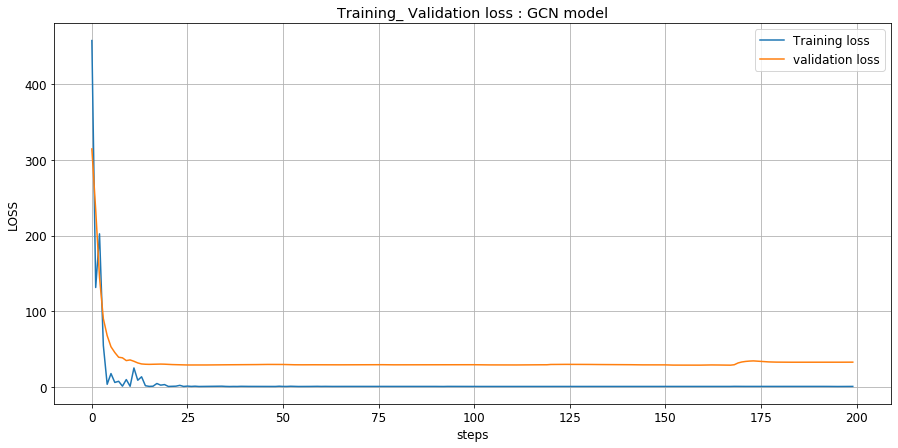

In [383]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_GCN)
plt.plot(range(n),LOSS_epoch_GCN[:],label= 'Training loss'   )
plt.plot(range(n),TEST_epoch_GCN[:], label= 'validation loss' )
plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Training_ Validation loss : GCN model' )
plt.savefig(PLOT_DIRECTORY + 'Training_vs_Validation_loss: model GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png') 

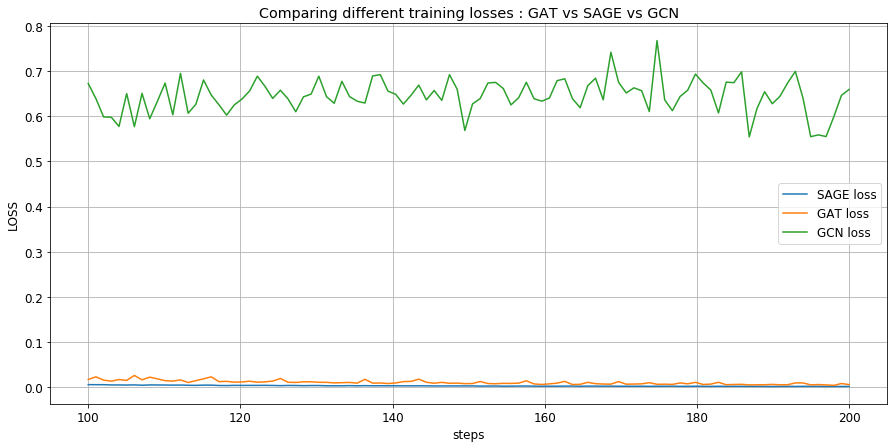

In [385]:
plt.figure(figsize=(15,7))
a=100
n = len(LOSS_epoch_GAT)
x = np.linspace(a,n,n-a)


plt.plot(x,LOSS_epoch_SAGE[a:],label= 'SAGE loss')
plt.plot(x,LOSS_epoch_GAT[a:], label= 'GAT loss' )
plt.plot(x,LOSS_epoch_GCN[a:], label= 'GCN loss' )

plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Comparing different training losses : GAT vs SAGE vs GCN' )
plt.savefig(PLOT_DIRECTORY + 'Comparaison Training losses GAT vs SAGE Vs GCN: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+')'+str(a)+'.png') 

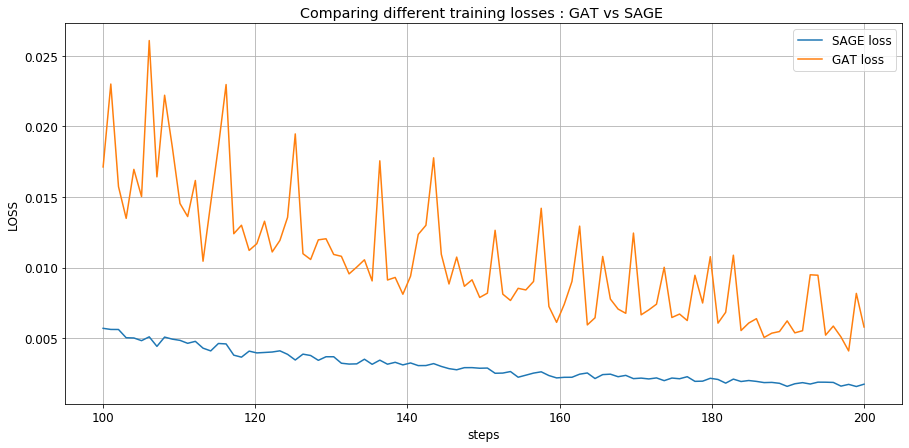

In [386]:
plt.figure(figsize=(15,7))
a=100
n = len(LOSS_epoch_GAT)
x = np.linspace(a,n,n-a)

plt.plot(x,LOSS_epoch_SAGE[a:],label= 'SAGE loss'   )
plt.plot(x,LOSS_epoch_GAT[a:], label= 'GAT loss' )

plt.xlabel('steps')
plt.ylabel('LOSS')
plt.grid()
plt.legend()
plt.title( 'Comparing different training losses : GAT vs SAGE ' )
plt.savefig(PLOT_DIRECTORY + 'Comparaison Training losses GAT vs SAGE: (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+')'+str(a)+'.png') 

In [ ]:
plt.figure(figsize=(15,7))
n = len(LOSS_epoch_GCN)
plt.plot(range(n),Train_accuracy_GCN[:],label= 'Training Accuracy'   )
plt.plot(range(n),Test_accuracy_GCN[:], label= 'Test Accuracy' )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title( 'Training- Test accuracy: GCN Model' )
plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN : (lr ='+str(Learning_rate)+') , (DROPOUT='+str(DROPOUT)+'), (CLASS_1_WEIGHT='+str(CLASS_1_WEIGHT)+').png')
#plt.savefig(PLOT_DIRECTORY + 'Train-Test Accuracy: model GCN Best.png')